## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress, ttest_ind, ranksums


from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
import matplotlib as mpl

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)[2:3]

# load data

In [97]:
susie_annotated_full = load_across_tissues(config, load_susie_annotated, tissue_ids = tissue_ids)

In [98]:
susie_annotated = susie_annotated_full

In [162]:
# break out by gene id so I can match vep effects to genes in the cluster
susie_annotated['gene_id'] = susie_annotated['cluster_id'].str.split('_')
susie_annotated_explode = susie_annotated.explode('gene_id')

def get_gene_matched_effect(row):
    gene_matched_effect = []
    for vep_effect in row['vep_info'].split(','):
        if row['gene_id'].split('.')[0] in vep_effect:
            gene_matched_effect.append(vep_effect.split('|')[1])
    return list(set(gene_matched_effect))

susie_annotated_explode['vep_info_gene'] = susie_annotated_explode.progress_apply(get_gene_matched_effect, axis=1).astype(str)
# if nmd of a gene
susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('NMD_transcript_variant')
# if in an exon
susie_annotated_explode['vep_gene_matched_exon'] = susie_annotated_explode['vep_info_gene'].str.contains('missense_variant|synonymous_variant|NMD_transcript_variant|exon_variant', regex=True)
# in in any part of the gene
susie_annotated_explode['vep_gene_matched_intron'] = susie_annotated_explode['vep_info_gene'].str.contains('UTR_variant|intron_variant|splice_region_variant|splice_polypyrimidine_tract_variant', regex=True)
# if near the gene in any way
susie_annotated_explode['vep_gene_matched_neargene'] = susie_annotated_explode['vep_info_gene'].str.contains('downstream_gene_variant|upstream_gene_variant', regex=True)
# any effect on the transcript
susie_annotated_explode['vep_any_effect'] = susie_annotated_explode['vep_info_gene'].str.strip("'[],").apply(len) > 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245871/245871 [00:11<00:00, 21889.37it/s]


In [163]:
# combine over variants in teh credible set for each gene in the cluster
col_names = ['vep_gene_matched_nmd', 'vep_gene_matched_exon', 'vep_gene_matched_intron', 'vep_gene_matched_neargene', 'vep_any_effect']
pip_weighted_col_names = []
for col in col_names:
    pip_weighted_col_names.append(f'pip_{col}')
    susie_annotated_explode[f'pip_{col}'] = susie_annotated_explode[col] * susie_annotated_explode['pip']
mean_agg_dict = dict([(col, 'mean') for col in pip_weighted_col_names])
mean_agg_dict

cs_grouped_gene_split = susie_annotated_explode.groupby(['cs_id', 'gene_id', 'tissue_id', 'phenotype_id', 'cluster_id']).agg(mean_agg_dict)

In [164]:
# 1 or both genes with effect? 
cs_grouped = cs_grouped_gene_split.groupby(['cs_id', 'tissue_id', 'phenotype_id', 'cluster_id']).agg(dict([(col, ['max', 'min', 'sum']) for col in pip_weighted_col_names])).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

cs_grouped['all_nmd'] = cs_grouped['pip_vep_gene_matched_nmd', 'min'] > 0
cs_grouped['any_nmd'] = cs_grouped['pip_vep_gene_matched_nmd', 'max'] > 0
cs_grouped['one_nmd'] = cs_grouped['any_nmd'] & ~ cs_grouped['all_nmd']
cs_grouped['all_in_gene'] = (cs_grouped['pip_vep_gene_matched_intron', 'min'] > 0) | (cs_grouped['pip_vep_gene_matched_exon', 'min'] > 0)
cs_grouped['all_near_gene'] = (cs_grouped['all_in_gene']) | (cs_grouped['pip_vep_gene_matched_neargene', 'min'] > 0)
cs_grouped['all_effect'] = cs_grouped['pip_vep_any_effect', 'min'] > 0
cs_grouped['one_effect'] = ~cs_grouped['all_effect'] & (cs_grouped['pip_vep_any_effect', 'max'] > 0)
cs_grouped['no_effect'] = cs_grouped['pip_vep_any_effect', 'max'] == 0

cs_grouped.columns = cs_grouped.columns.map(lambda x: '_'.join(x).rstrip('_'))  # Create new single-level column names
cs_grouped

cs_id      tissue_id  \
0     ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...  Artery_Tibial   
1     ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...  Artery_Tibial   
2        ENSG00000000971.15_ENSG00000162687.16_pc1_cs_1  Artery_Tibial   
3     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...  Artery_Tibial   
4     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...  Artery_Tibial   
...                                                 ...            ...   
3024       ENSG00000276070.4_ENSG00000276085.1_pc1_cs_2  Artery_Tibial   
3025  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...  Artery_Tibial   
3026  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...  Artery_Tibial   
3027  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...  Artery_Tibial   
3028  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...  Artery_Tibial   

                                           phenotype_id  \
0     ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...   
1     ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...   
2             ENSG00000000971.15_ENSG00000162687.16_pc1   
3     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...   
4     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...   
...                                                 ...   
3024            ENSG00000276070.4_ENSG00000276085.1_pc1   
3025  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3026  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3027  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3028  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   

                                             cluster_id  \
0                 ENSG00000000971.15_ENSG00000162687.16   
1                 ENSG00000000971.15_ENSG00000162687.16   
2                 ENSG00000000971.15_ENSG00000162687.16   
3     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...   
4     ENSG00000001460.17_ENSG00000001461.16_ENSG0000...   
...                                                 ...   
3024                ENSG00000276070.4_ENSG00000276085.1   
3025  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3026  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3027  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   
3028  ENSG00000278259.4_ENSG00000278311.4_ENSG000002...   

      pip_vep_gene_matched_nmd_max  pip_vep_gene_matched_nmd_min  \
0                         0.034142                           0.0   
1                         0.037926                           0.0   
2                         0.038076                           0.0   
3                         0.000000                           0.0   
4                         0.000000                           0.0   
...                            ...                           ...   
3024                      0.000000                           0.0   
3025                      0.000000                           0.0   
3026                      0.007739                           0.0   
3027                      0.001281                           0.0   
3028                      0.022030                           0.0   

      pip_vep_gene_matched_nmd_sum  pip_vep_gene_matched_exon_max  \
0                         0.034142                       0.034142   
1                         0.037926                       0.037926   
2                         0.038076                       0.038076   
3                         0.000000                       0.033659   
4                         0.000000                       0.001100   
...                            ...                            ...   
3024                      0.000000                       0.000000   
3025                      0.000000                       0.000000   
3026                      0.007739                       0.007739   
3027                      0.001662                       0.002356   
3028                      0.022030                       0.022030   

      pip_vep_gene_matched_exon_min  pip_vep_gene_matched_exon_sum  ...  \
0                     

In [165]:
# combine over genes in the cluster for each credible set
cs_grouped[cs_grouped['cluster_size']==2].groupby('pc_order').agg(dict([((col), 'mean') for col in ['all_nmd', 'any_nmd', 'all_in_gene', 'all_near_gene', 'one_nmd', 'all_effect', 'one_effect', 'no_effect']]))

all_nmd   any_nmd  all_in_gene  all_near_gene   one_nmd  \
pc_order                                                             
eqtl      0.034003  0.351623     0.232612       0.353168  0.317620   
first     0.031519  0.358166     0.233524       0.348138  0.326648   
last      0.025974  0.380334     0.254174       0.374768  0.354360   

          all_effect  one_effect  no_effect  
pc_order                                     
eqtl        0.372488    0.455951   0.171561  
first       0.363897    0.469914   0.166189  
last        0.393321    0.484230   0.122449

/local/scratch/klawren/slrmtmp.46976361/ipykernel_269214/1424294807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_grouped_to_plot['eqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'eqtl'
/local/scratch/klawren/slrmtmp.46976361/ipykernel_269214/1424294807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_grouped_to_plot['first_pcqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'first'
/local/scratch/klawren/slrmtmp.46976361/ipykernel_269214/1424294807.py:7: SettingWithCopyWarning: 
A value is tryi

all_nmd
Optimization terminated successfully.
         Current function value: 0.692637
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3029
Model:                          Logit   Df Residuals:                     3026
Method:                           MLE   Df Model:                            2
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:               8.526e-05
Time:                        15:19:24   Log-Likelihood:                -2098.0
converged:                       True   LL-Null:                       -2098.2
Covariance Type:            nonrobust   LLR p-value:                    0.8362
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0633      0.099      0.642      0.521      -0.130       0.257
cluster_size   

(0.05, 50)

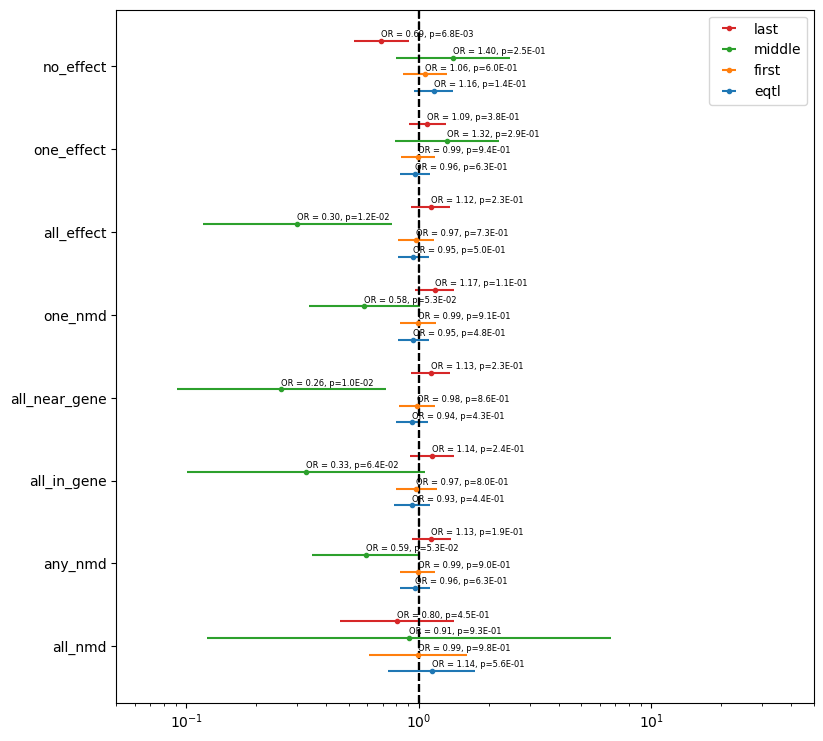

In [166]:
# log odds plot
cs_grouped_to_plot = cs_grouped[['pc_order', 'cluster_size', *col_list]]
cs_grouped_to_plot.columns = cs_grouped_to_plot.columns.get_level_values(0)

cs_grouped_to_plot['eqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'eqtl'
cs_grouped_to_plot['first_pcqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'first'
cs_grouped_to_plot['middle_pcqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'middle'
cs_grouped_to_plot['last_pcqtl_bool'] = cs_grouped_to_plot['pc_order'] == 'last'

col_list = ['all_nmd', 'any_nmd', 'all_in_gene', 'all_near_gene', 'one_nmd', 'all_effect', 'one_effect', 'no_effect']

ax = make_log_odds_plot_multiple([get_odds_df(cs_grouped_to_plot, label_col='eqtl_bool', column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(cs_grouped_to_plot, label_col='first_pcqtl_bool', column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(cs_grouped_to_plot, label_col='middle_pcqtl_bool', column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(cs_grouped_to_plot, label_col='last_pcqtl_bool', column_list=col_list, correct_on=True, correct_on_column='cluster_size')], 
                                  labels=['eqtl', 'first', 'middle', 'last'])
ax.set_xlim(.05, 50)

In [167]:
# combine over signal groups
signal_groups = load_across_tissues(config, load_signal_groups, tissue_ids = tissue_ids)

In [168]:
# add in signal group information
signal_groups['cs_id'] = signal_groups['signal_id'].str.split('-')
signal_groups_explode = signal_groups.explode('cs_id')
signal_groups_explode = pd.merge(signal_groups_explode, cs_grouped, on=['cs_id', 'tissue_id', 'cluster_id'])

signal_groups_annotated = signal_groups_explode.groupby(['signal_id', 'cluster_id', 'tissue_id']).agg({'cs_id':list,
                                                                             'num_e_coloc':'first',
                                                                             'num_pc_coloc':'first',
                                                                             'all_nmd':'max',
                                                                             'any_nmd':'max',
                                                                             'all_in_gene':'max', 
                                                                             'all_near_gene':'max', 
                                                                             'one_nmd':'max',
                                                                             'all_effect':'max', 
                                                                             'one_effect':'max', 
                                                                             'no_effect':'min', 
                                                                             'cluster_size':'first'})

signal_groups_annotated['exclusive_label'] = np.where((signal_groups_annotated['num_e_coloc'] > 0), np.where((signal_groups_annotated['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


all_nmd
Optimization terminated successfully.
         Current function value: 0.688981
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  849
Model:                          Logit   Df Residuals:                      846
Method:                           MLE   Df Model:                            2
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:                0.002293
Time:                        15:19:32   Log-Likelihood:                -584.94
converged:                       True   LL-Null:                       -586.29
Covariance Type:            nonrobust   LLR p-value:                    0.2607
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2753      0.166     -1.658      0.097      -0.601       0.050
cluster_size   

(0.01, 100)

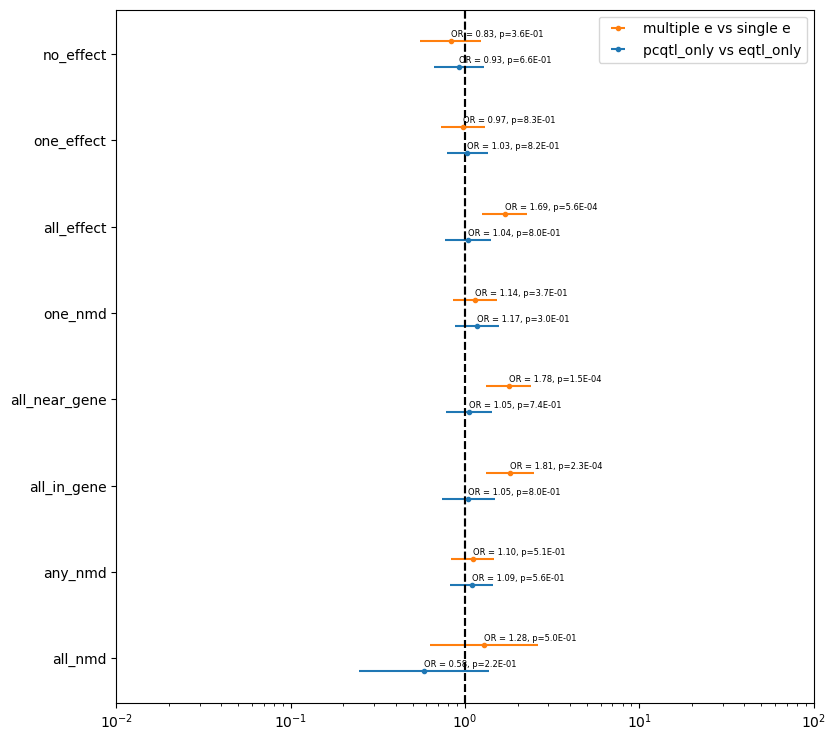

In [169]:
signal_groups_annotated['pcqtl_only_bool'] = signal_groups_annotated['exclusive_label'] == 'pcqtl_only'
signal_groups_annotated['shared_bool'] = signal_groups_annotated['exclusive_label'] == 'shared'
signal_groups_annotated['eqtl_only_bool'] = signal_groups_annotated['exclusive_label'] == 'eqtl_only'
signal_groups_annotated['multiple_e_bool'] = signal_groups_annotated['num_e_coloc'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(signal_groups_annotated[signal_groups_annotated['exclusive_label'].isin(['pcqtl_only', 'eqtl_only'])], label_col='pcqtl_only_bool',column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(signal_groups_annotated[signal_groups_annotated['num_e_coloc'] >0], label_col='multiple_e_bool', column_list=col_list, correct_on=True, correct_on_column='cluster_size')], 
                                  labels=['pcqtl_only vs eqtl_only', 'multiple e vs single e'], 
                                   offset = 0.3)

ax.set_xlim(.01, 100)

all_nmd
Optimization terminated successfully.
         Current function value: 0.537466
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1697
Model:                          Logit   Df Residuals:                     1694
Method:                           MLE   Df Model:                            2
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:                0.008165
Time:                        15:19:33   Log-Likelihood:                -912.08
converged:                       True   LL-Null:                       -919.59
Covariance Type:            nonrobust   LLR p-value:                 0.0005483
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.6415      0.141    -11.620      0.000      -1.918      -1.365
cluster_size   

(0.01, 100)

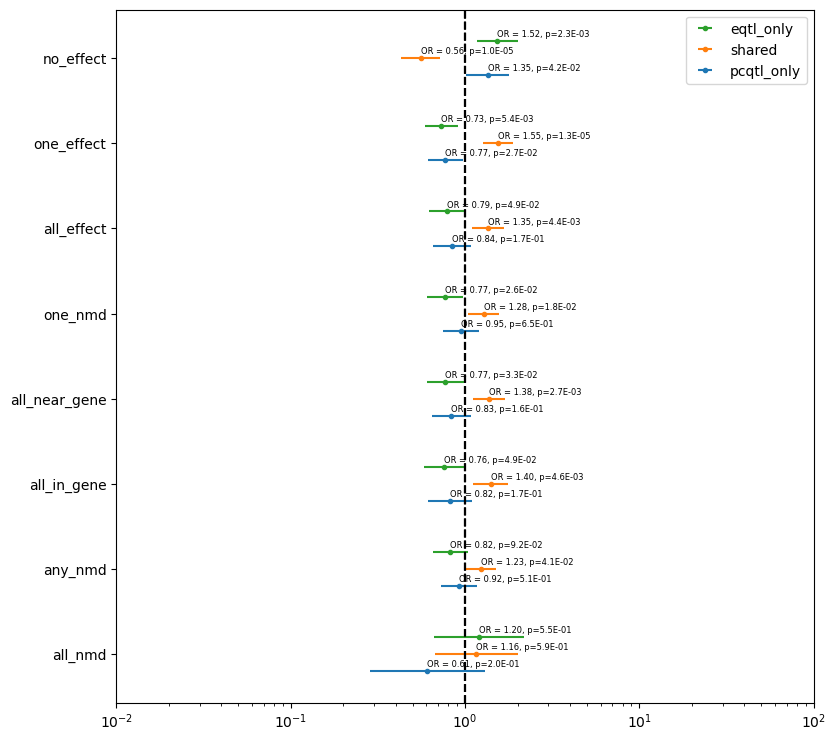

In [170]:
ax = make_log_odds_plot_multiple([get_odds_df(signal_groups_annotated, label_col='pcqtl_only_bool',column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(signal_groups_annotated, label_col='shared_bool',column_list=col_list, correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(signal_groups_annotated, label_col='eqtl_only_bool',column_list=col_list, correct_on=True, correct_on_column='cluster_size')],
                                  labels=['pcqtl_only', 'shared', 'eqtl_only'], 
                                   offset = 0.2)

ax.set_xlim(.01, 100)

## old version wtihout splitting vep categories

In [13]:
# add vep categories here
# should vep be transcript matched?

# make nulls no info
susie_annotated['vep_info'] =susie_annotated['vep_info'].astype(str)

susie_annotated['vep_nmd'] = susie_annotated['vep_info'].str.contains('NMD_transcript_variant')
susie_annotated['vep_enhancer'] = susie_annotated['vep_info'].str.contains('enhancer')
susie_annotated['vep_promoter'] = susie_annotated['vep_info'].str.contains('promoter')
susie_annotated['vep_CTCF'] = susie_annotated['vep_info'].str.contains('CTCF_binding_site')
susie_annotated['vep_TF'] = susie_annotated['vep_info'].str.contains('TF_binding_site')
susie_annotated['vep_open_chrom'] = susie_annotated['vep_info'].str.contains('open_chromatin_region')
susie_annotated['vep_reg'] = susie_annotated['vep_info'].str.contains('regulatory_region_variant')


# add other annotation cats
susie_annotated['in_enhancer'] = (susie_annotated['qtl_num_abc_enhancers'] > 0)
susie_annotated['in_matched_enhancer'] = (susie_annotated['qtl_matched_abc_genes'] > 0)
susie_annotated['in_multiple_matched_enhancer'] = (susie_annotated['qtl_matched_abc_genes'] > 1)

# pip weighted

In [14]:
col_names = ['in_enhancer', 'in_matched_enhancer', 'in_multiple_matched_enhancer', 'in_bidirectional_promoter', 'in_shared_promoter', 
              'qtl_in_ctcf', 'qtl_in_tad', 'qtl_in_tad_ctcf', 'vep_nmd', 'vep_enhancer', 'vep_promoter', 'vep_CTCF', 'vep_TF', 'vep_open_chrom', 'vep_reg']
pip_weighted_col_names = []
for col in col_names:
    pip_weighted_col_names.append(f'pip_{col}')
    susie_annotated[f'pip_{col}'] = susie_annotated[col] * susie_annotated['pip']

mean_agg_dict = dict([(col, 'mean') for col in pip_weighted_col_names])
susie_annotated.groupby('type').agg(mean_agg_dict)

pip_in_enhancer  pip_in_matched_enhancer  \
type                                              
eqtl          0.000411                 0.000198   
pcqtl         0.000402                 0.000187   

       pip_in_multiple_matched_enhancer  pip_in_bidirectional_promoter  \
type                                                                     
eqtl                           0.000072                       0.002809   
pcqtl                          0.000056                       0.002483   

       pip_in_shared_promoter  pip_qtl_in_ctcf  pip_qtl_in_tad  \
type                                                             
eqtl                 0.030324         0.000620        0.001317   
pcqtl                0.028739         0.000546        0.001264   

       pip_qtl_in_tad_ctcf  pip_vep_nmd  pip_vep_enhancer  pip_vep_promoter  \
type                                                                          
eqtl              0.000022     0.010953          0.004505          0.002769   
pcqtl             0.000030     0.010551          0.004029          0.002672   

       pip_vep_CTCF  pip_vep_TF  pip_vep_open_chrom  pip_vep_reg  
type                                                              
eqtl       0.000137         0.0            0.000107     0.007432  
pcqtl      0.000125         0.0            0.000093     0.006845

In [15]:
# group over credible sets
sum_agg_dict = dict([(col, 'sum') for col in pip_weighted_col_names])
sum_agg_dict['type'] = 'first'
sum_agg_dict['cluster_id'] = 'first'
sum_agg_dict['lead_variant_id'] = 'first'
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg(sum_agg_dict).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

cs_grouped.groupby('pc_order').agg(mean_agg_dict)

pip_in_enhancer  pip_in_matched_enhancer  \
pc_order                                             
eqtl             0.009754                 0.004697   
first            0.009238                 0.003904   
last             0.010706                 0.005558   
middle           0.010597                 0.004928   

          pip_in_multiple_matched_enhancer  pip_in_bidirectional_promoter  \
pc_order                                                                    
eqtl                              0.001706                       0.066689   
first                             0.001539                       0.064367   
last                              0.001324                       0.054575   
middle                            0.000645                       0.072909   

          pip_in_shared_promoter  pip_qtl_in_ctcf  pip_qtl_in_tad  \
pc_order                                                            
eqtl                    0.719957         0.014722        0.031277   
first                   0.709481         0.013881        0.033887   
last                    0.688261         0.013234        0.029789   
middle                  0.806907         0.011932        0.020714   

          pip_qtl_in_tad_ctcf  pip_vep_nmd  pip_vep_enhancer  \
pc_order                                                       
eqtl                 0.000531     0.260052          0.106962   
first                0.000636     0.258237          0.112783   
last                 0.000986     0.279640          0.086660   
middle               0.000276     0.186478          0.074018   

          pip_vep_promoter  pip_vep_CTCF  pip_vep_TF  pip_vep_open_chrom  \
pc_order                                                                   
eqtl              0.065751      0.003247         0.0            0.002530   
first             0.064403      0.002671         0.0            0.002276   
last              0.064445      0.003438         0.0            0.002326   
middle            0.082767      0.004192         0.0            0.002355   

          pip_vep_reg  
pc_order               
eqtl         0.176461  
first        0.180628  
last         0.154326  
middle       0.162554

pip_in_enhancer
Optimization terminated successfully.
         Current function value: 0.692828
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34325
Model:                          Logit   Df Residuals:                    34323
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:               9.364e-07
Time:                        16:03:46   Log-Likelihood:                -23781.
converged:                       True   LL-Null:                       -23781.
Covariance Type:            nonrobust   LLR p-value:                    0.8329
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0508      0.011      4.665      0.000       0.029       0.07

(0.05, 50)

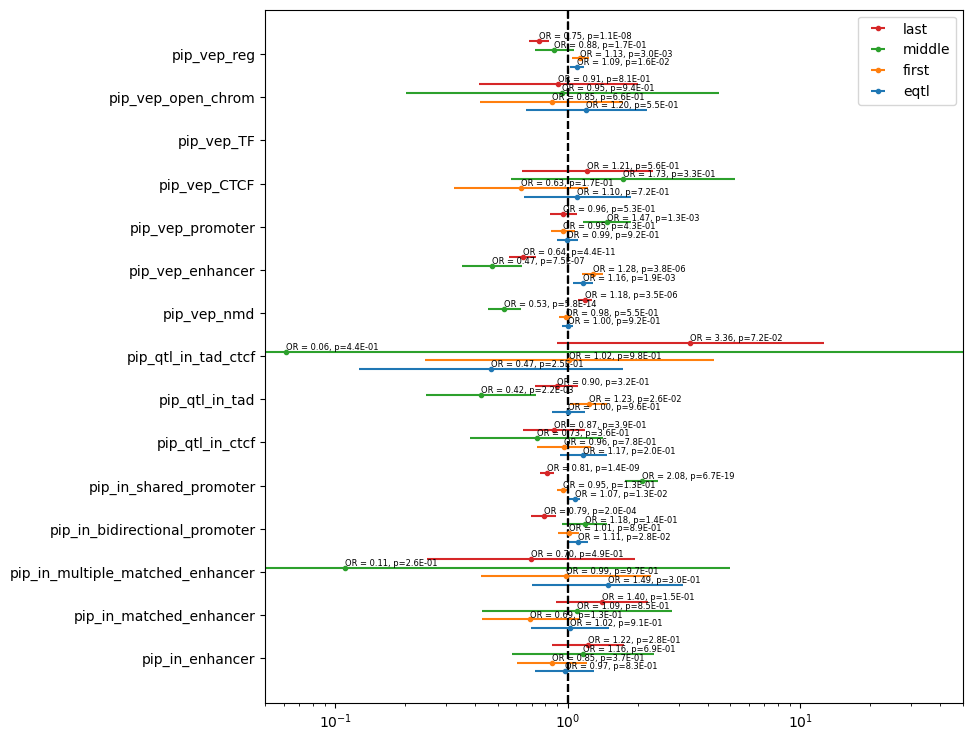

In [16]:
# log odds plot
cs_grouped['eqtl_bool'] = cs_grouped['pc_order'] == 'eqtl'
cs_grouped['first_pcqtl_bool'] = cs_grouped['pc_order'] == 'first'
cs_grouped['middle_pcqtl_bool'] = cs_grouped['pc_order'] == 'middle'
cs_grouped['last_pcqtl_bool'] = cs_grouped['pc_order'] == 'last'

ax = make_log_odds_plot_multiple([get_odds_df(cs_grouped, label_col='eqtl_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(cs_grouped, label_col='first_pcqtl_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(cs_grouped, label_col='middle_pcqtl_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(cs_grouped, label_col='last_pcqtl_bool', column_list=pip_weighted_col_names)], 
                                  labels=['eqtl', 'first', 'middle', 'last'])
ax.set_xlim(.05, 50)

In [174]:
# group by lead variant
# group by colocs instead TODO
mean_agg_dict['cs_id'] = list
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg(mean_agg_dict)
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
lead_var_grouped.groupby('exclusive_label').agg(mean_agg_dict)



pip_in_enhancer  pip_in_matched_enhancer  \
exclusive_label                                             
eqtl_only               0.010057                 0.003842   
pcqtl_only              0.009699                 0.003435   
shared                  0.011436                 0.006670   

                 pip_in_multiple_matched_enhancer  \
exclusive_label                                     
eqtl_only                                0.001455   
pcqtl_only                               0.001284   
shared                                   0.002253   

                 pip_in_bidirectional_promoter  pip_in_shared_promoter  \
exclusive_label                                                          
eqtl_only                             0.063575                0.695948   
pcqtl_only                            0.059393                0.682111   
shared                                0.066162                0.736314   

                 pip_qtl_in_ctcf  pip_qtl_in_tad  pip_qtl_in_tad_ctcf  \
exclusive_label                                                         
eqtl_only               0.011569        0.027482             0.000782   
pcqtl_only              0.008057        0.027130             0.000932   
shared                  0.014949        0.034018             0.000435   

                 pip_vep_nmd  pip_vep_enhancer  pip_vep_promoter  \
exclusive_label                                                    
eqtl_only           0.261342          0.092447          0.048573   
pcqtl_only          0.258306          0.079908          0.042054   
shared              0.255436          0.123761          0.098471   

                 pip_vep_CTCF  pip_vep_TF  pip_vep_open_chrom  pip_vep_reg  \
exclusive_label                                                              
eqtl_only            0.006173    0.006221            0.016593     0.160757   
pcqtl_only           0.005775    0.004756            0.015728     0.140304   
shared               0.007638    0.010688            0.021958     0.246843   

                                                             cs_id  
exclusive_label                                                     
eqtl_only        [[ENSG00000095485.16_ENSG00000196072.11_e_ENSG...  
pcqtl_only       [[ENSG00000095485.16_ENSG00000196072.11_pc1_2]...  
shared           [[ENSG00000095485.16_ENSG00000196072.11_e_ENSG...

pip_in_enhancer
Optimization terminated successfully.
         Current function value: 0.692887
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23392
Model:                          Logit   Df Residuals:                    23390
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               5.239e-06
Time:                        20:37:26   Log-Likelihood:                -16208.
converged:                       True   LL-Null:                       -16208.
Covariance Type:            nonrobust   LLR p-value:                    0.6803
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0445      0.013     -3.366      0.001      -0.070      -0.01

(0.01, 100)

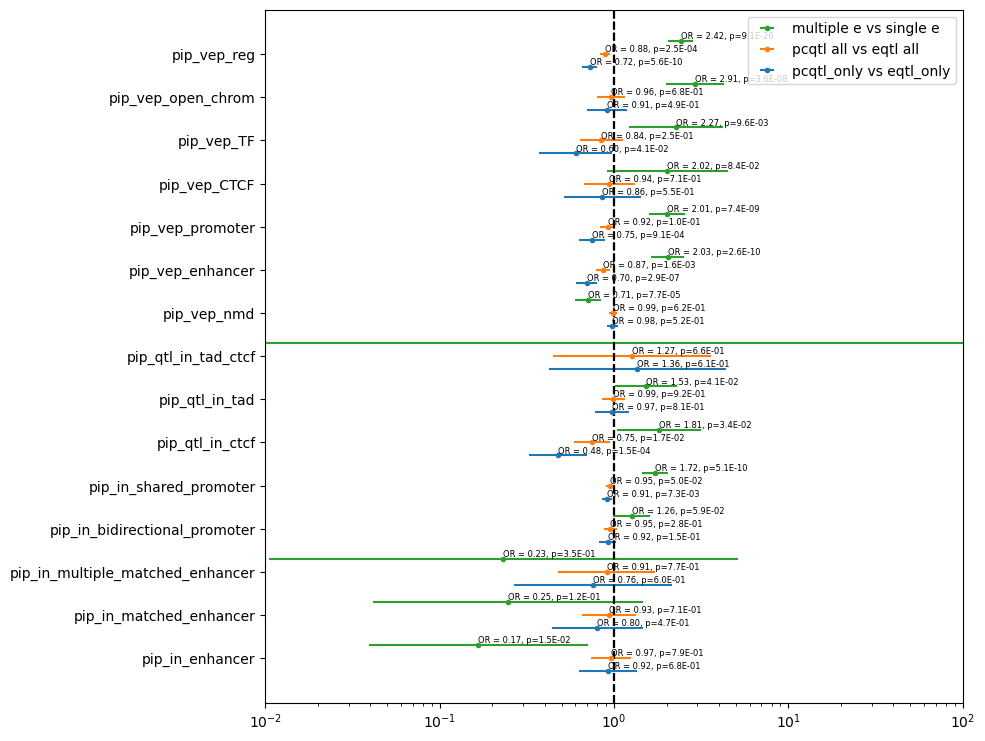

In [175]:
# log odds plot

# make one that has a pcqtl and eqtl entry for each shared signal
lead_var_grouped['type'] = np.where(lead_var_grouped['exclusive_label'].isin(['pcqtl_only', 'shared']), 'pcqtl', 'eqtl')
shared_copy = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].copy()
shared_copy['type'] = 'eqtl'
lead_var_grouped_split = pd.concat([lead_var_grouped, shared_copy])
lead_var_grouped_split['pcqtl_bool'] = lead_var_grouped_split['type'] == 'pcqtl'


lead_var_grouped['pcqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'pcqtl_only'
lead_var_grouped['shared_bool'] = lead_var_grouped['exclusive_label'] == 'shared'
lead_var_grouped['eqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'eqtl_only'
lead_var_grouped['multiple_e_bool'] = lead_var_grouped['num_e_samelead'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(lead_var_grouped[lead_var_grouped['exclusive_label'].isin(['pcqtl_only', 'eqtl_only'])], label_col='pcqtl_only_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(lead_var_grouped_split, label_col='pcqtl_bool', column_list=pip_weighted_col_names), 
                                  get_odds_df(lead_var_grouped[lead_var_grouped['num_e_samelead'] >0], label_col='multiple_e_bool', column_list=pip_weighted_col_names)], 
                                  labels=['pcqtl_only vs eqtl_only', 'pcqtl all vs eqtl all', 'multiple e vs single e'], 
                                   offset = 0.3)

ax.set_xlim(.01, 100)

pip_in_enhancer
Optimization terminated successfully.
         Current function value: 0.657585
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31106
Model:                          Logit   Df Residuals:                    31104
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               2.790e-05
Time:                        20:37:34   Log-Likelihood:                -20455.
converged:                       True   LL-Null:                       -20455.
Covariance Type:            nonrobust   LLR p-value:                    0.2853
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5412      0.012    -45.564      0.000      -0.565      -0.51

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31106
Model:                          Logit   Df Residuals:                    31104
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               9.560e-05
Time:                        20:37:35   Log-Likelihood:                -20453.
converged:                       True   LL-Null:                       -20455.
Covariance Type:            nonrobust   LLR p-value:                   0.04797
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.5365      0.012    -43.975      0.000      -0.560      -0.513
pip_in_bidirectional_promoter    -0.1045      0.053     -1.969      0.049 

(0.01, 100)

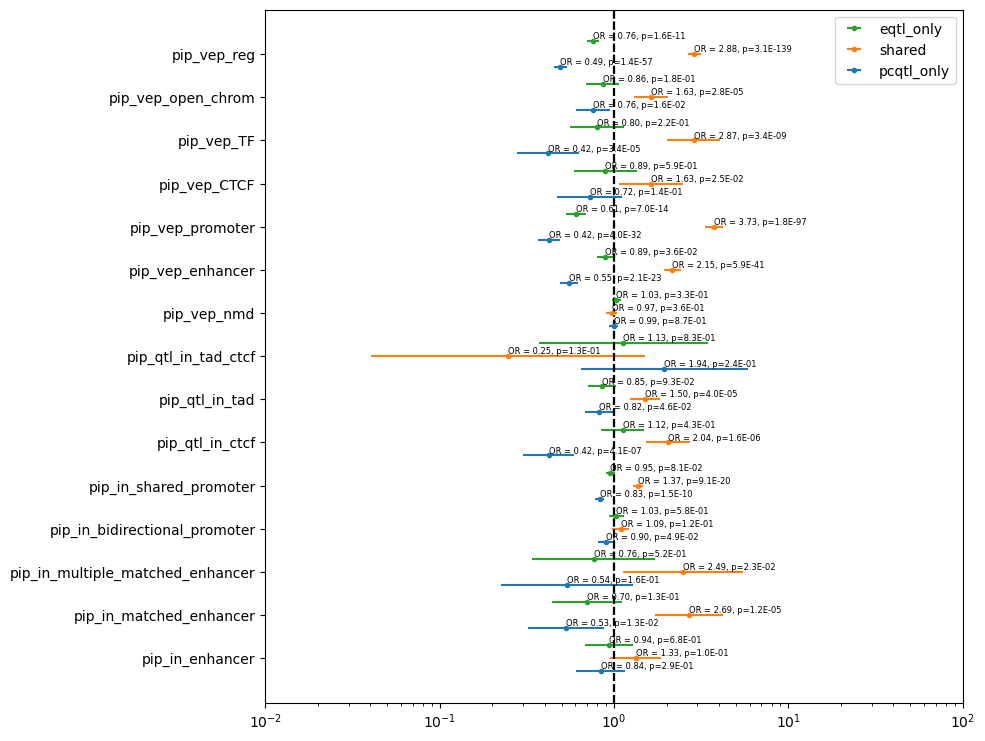

In [176]:
# log odds plot
lead_var_grouped['pcqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'pcqtl_only'
lead_var_grouped['shared_bool'] = lead_var_grouped['exclusive_label'] == 'shared'
lead_var_grouped['eqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'eqtl_only'
lead_var_grouped['multiple_e_bool'] = lead_var_grouped['num_e_samelead'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(lead_var_grouped, label_col='pcqtl_only_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(lead_var_grouped, label_col='shared_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(lead_var_grouped, label_col='eqtl_only_bool', column_list=pip_weighted_col_names)], 
                                  labels=['pcqtl_only', 'shared', 'eqtl_only'], 
                                   offset = 0.3)

ax.set_xlim(.01, 100)

#### clusters with both signals only
to try to get around threshold effects

In [186]:
shared_ids = susie_annotated[susie_annotated['type']=='eqtl']['cluster_id']
shared_ids = shared_ids[shared_ids.isin(susie_annotated[susie_annotated['type']=='pcqtl']['cluster_id'])].unique()

In [191]:
cs_grouped = cs_grouped[cs_grouped['cluster_id'].isin(shared_ids)]

# group by lead variant
# group by colocs instead TODO
mean_agg_dict['cs_id'] = list
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg(mean_agg_dict)
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
lead_var_grouped.groupby('exclusive_label').agg(mean_agg_dict)


pip_in_enhancer  pip_in_matched_enhancer  \
exclusive_label                                             
eqtl_only               0.010130                 0.003906   
pcqtl_only              0.009762                 0.003451   
shared                  0.011436                 0.006670   

                 pip_in_multiple_matched_enhancer  \
exclusive_label                                     
eqtl_only                                0.001487   
pcqtl_only                               0.001273   
shared                                   0.002253   

                 pip_in_bidirectional_promoter  pip_in_shared_promoter  \
exclusive_label                                                          
eqtl_only                             0.064114                0.696916   
pcqtl_only                            0.059292                0.683083   
shared                                0.066162                0.736314   

                 pip_qtl_in_ctcf  pip_qtl_in_tad  pip_qtl_in_tad_ctcf  \
exclusive_label                                                         
eqtl_only               0.011334        0.027762             0.000718   
pcqtl_only              0.008118        0.027113             0.000946   
shared                  0.014949        0.034018             0.000435   

                 pip_vep_nmd  pip_vep_enhancer  pip_vep_promoter  \
exclusive_label                                                    
eqtl_only           0.262459          0.092515          0.048784   
pcqtl_only          0.258419          0.079949          0.042189   
shared              0.255436          0.123761          0.098471   

                 pip_vep_CTCF  pip_vep_TF  pip_vep_open_chrom  pip_vep_reg  \
exclusive_label                                                              
eqtl_only            0.006271    0.006296            0.016285     0.160759   
pcqtl_only           0.005746    0.004803            0.015681     0.140433   
shared               0.007638    0.010688            0.021958     0.246843   

                                                             cs_id  
exclusive_label                                                     
eqtl_only        [[ENSG00000095485.16_ENSG00000196072.11_e_ENSG...  
pcqtl_only       [[ENSG00000095485.16_ENSG00000196072.11_pc1_2]...  
shared           [[ENSG00000095485.16_ENSG00000196072.11_e_ENSG...

pip_in_enhancer
Optimization terminated successfully.
         Current function value: 0.657475
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                30674
Model:                          Logit   Df Residuals:                    30672
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               2.691e-05
Time:                        20:42:12   Log-Likelihood:                -20167.
converged:                       True   LL-Null:                       -20168.
Covariance Type:            nonrobust   LLR p-value:                    0.2975
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5421      0.012    -45.318      0.000      -0.566      -0.51

(0.01, 100)

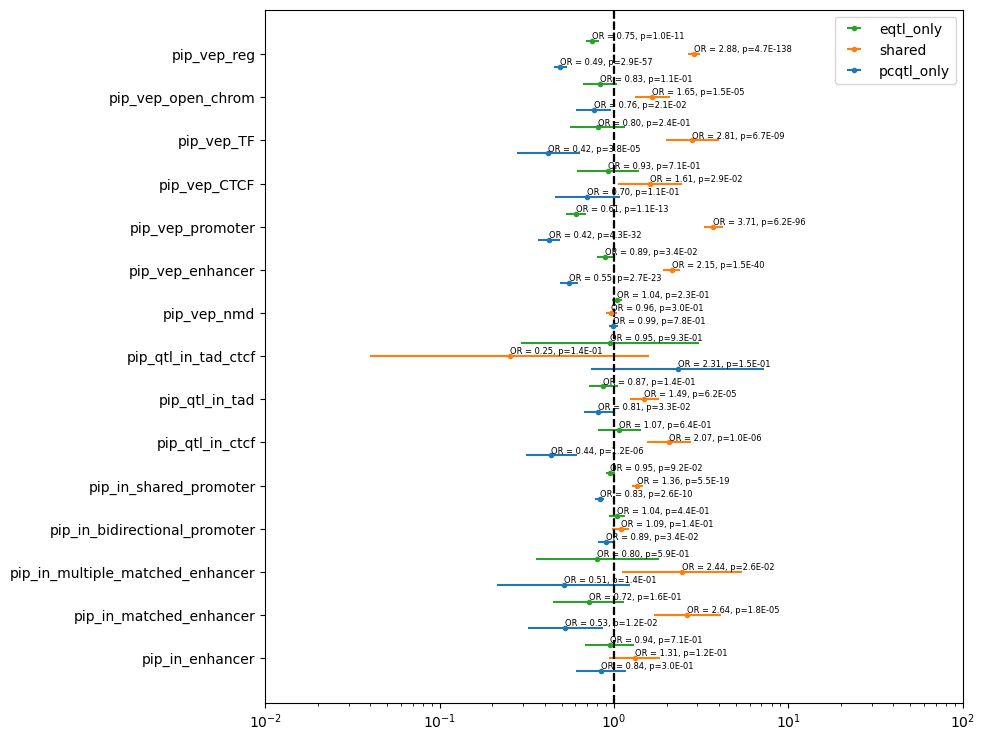

In [192]:
# log odds plot
lead_var_grouped['pcqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'pcqtl_only'
lead_var_grouped['shared_bool'] = lead_var_grouped['exclusive_label'] == 'shared'
lead_var_grouped['eqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'eqtl_only'
lead_var_grouped['multiple_e_bool'] = lead_var_grouped['num_e_samelead'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(lead_var_grouped, label_col='pcqtl_only_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(lead_var_grouped, label_col='shared_bool', column_list=pip_weighted_col_names),
                                  get_odds_df(lead_var_grouped, label_col='eqtl_only_bool', column_list=pip_weighted_col_names)], 
                                  labels=['pcqtl_only', 'shared', 'eqtl_only'], 
                                   offset = 0.3)

ax.set_xlim(.01, 100)

# max version
if any of the variants belongs to a category, put it in the category

In [159]:
# group over credible sets
max_agg_dict = dict([(col, 'max') for col in col_names])
max_agg_dict['type'] = 'first'
max_agg_dict['cluster_id'] = 'first'
max_agg_dict['lead_variant_id'] = 'first'
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg(max_agg_dict).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

In [120]:
cs_grouped.groupby('pc_order').agg(dict([(col, 'mean') for col in col_names]))

in_enhancer  in_matched_enhancer  in_multiple_matched_enhancer  \
pc_order                                                                   
eqtl         0.066380             0.022159                      0.009121   
first        0.068403             0.023373                      0.009540   
last         0.072315             0.024564                      0.008648   
middle       0.062644             0.019540                      0.007471   

          in_bidirectional_promoter  in_shared_promoter  qtl_in_ctcf  \
pc_order                                                               
eqtl                       0.090306            0.839398     0.064947   
first                      0.089868            0.830280     0.063919   
last                       0.081589            0.827547     0.069683   
middle                     0.102874            0.883333     0.060920   

          qtl_in_tad  qtl_in_tad_ctcf   vep_nmd  vep_enhancer  vep_promoter  \
pc_order                                                                      
eqtl        0.132951         0.004202  0.428653      0.410172      0.240497   
first       0.134326         0.004484  0.424633      0.416714      0.238313   
last        0.142123         0.004136  0.461211      0.405565      0.251285   
middle      0.105747         0.004598  0.345977      0.356897      0.295977   

          vep_CTCF    vep_TF  vep_open_chrom   vep_reg  
pc_order                                                
eqtl      0.042932  0.029274        0.065091  0.556447  
first     0.043885  0.028334        0.064682  0.564110  
last      0.049505  0.026068        0.069683  0.549442  
middle    0.060920  0.042529        0.080460  0.545977

in_enhancer
Optimization terminated successfully.
         Current function value: 0.692967
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41141
Model:                          Logit   Df Residuals:                    41139
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               2.689e-05
Time:                        20:19:52   Log-Likelihood:                -28509.
converged:                       True   LL-Null:                       -28510.
Covariance Type:            nonrobust   LLR p-value:                    0.2157
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0392      0.010      3.840      0.000       0.019       0.059
in_enhancer   

(0.05, 50)

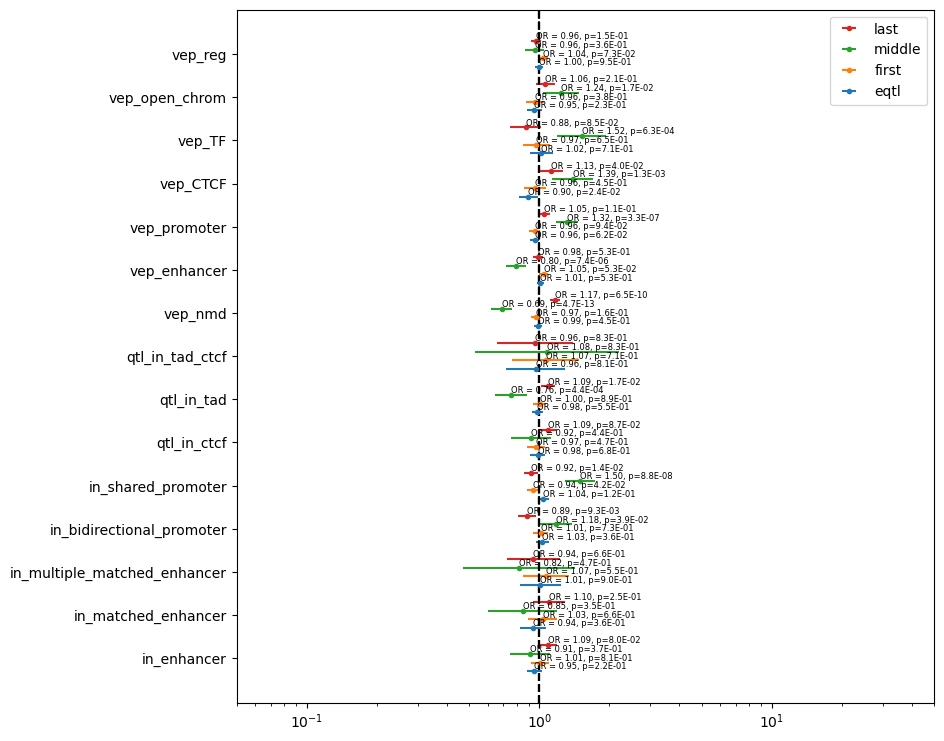

In [122]:
cs_grouped['eqtl_bool'] = cs_grouped['pc_order'] == 'eqtl'
cs_grouped['first_pcqtl_bool'] = cs_grouped['pc_order'] == 'first'
cs_grouped['middle_pcqtl_bool'] = cs_grouped['pc_order'] == 'middle'
cs_grouped['last_pcqtl_bool'] = cs_grouped['pc_order'] == 'last'

ax = make_log_odds_plot_multiple([get_odds_df(cs_grouped, label_col='eqtl_bool', column_list=col_names),
                                  get_odds_df(cs_grouped, label_col='first_pcqtl_bool', column_list=col_names),
                                  get_odds_df(cs_grouped, label_col='middle_pcqtl_bool', column_list=col_names),
                                  get_odds_df(cs_grouped, label_col='last_pcqtl_bool', column_list=col_names)], 
                                  labels=['eqtl', 'first', 'middle', 'last'])

In [168]:
# group by lead variant
# group by colocs instead TODO
max_agg_dict = dict([(col, 'mean') for col in col_names])
max_agg_dict['cs_id'] = list
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg(max_agg_dict)
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


# make one that has a pcqtl and eqtl entry for each shared signal
lead_var_grouped['type'] = np.where(lead_var_grouped['exclusive_label'].isin(['pcqtl_only', 'shared']), 'pcqtl', 'eqtl')
shared_copy = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].copy()
shared_copy['type'] = 'eqtl'
lead_var_grouped_split = pd.concat([lead_var_grouped, shared_copy])
lead_var_grouped_split['pcqtl_bool'] = lead_var_grouped_split['type'] == 'pcqtl'

lead_var_grouped.groupby('exclusive_label').agg(dict([(col, 'mean') for col in col_names]))

in_enhancer  in_matched_enhancer  \
exclusive_label                                     
eqtl_only           0.083020             0.026294   
pcqtl_only          0.086738             0.027600   
shared              0.048472             0.018797   

                 in_multiple_matched_enhancer  in_bidirectional_promoter  \
exclusive_label                                                            
eqtl_only                            0.010910                   0.091924   
pcqtl_only                           0.010760                   0.089756   
shared                               0.007324                   0.087622   

                 in_shared_promoter  qtl_in_ctcf  qtl_in_tad  qtl_in_tad_ctcf  \
exclusive_label                                                                 
eqtl_only                  0.845456     0.076039    0.153164         0.004933   
pcqtl_only                 0.836410     0.076240    0.156111         0.005336   
shared                     0.830028     0.053971    0.110924         0.003479   

                  vep_nmd  vep_enhancer  vep_promoter  vep_CTCF    vep_TF  \
exclusive_label                                                             
eqtl_only        0.475072      0.465283      0.260144  0.051417  0.030558   
pcqtl_only       0.472618      0.457003      0.261176  0.058525  0.028913   
shared           0.383903      0.350402      0.226130  0.033094  0.027385   

                 vep_open_chrom   vep_reg  
exclusive_label                            
eqtl_only              0.072318  0.594557  
pcqtl_only             0.077815  0.583545  
shared                 0.055300  0.520547

in_enhancer
Optimization terminated successfully.
         Current function value: 0.692868
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23392
Model:                          Logit   Df Residuals:                    23390
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               3.211e-05
Time:                        20:34:55   Log-Likelihood:                -16208.
converged:                       True   LL-Null:                       -16208.
Covariance Type:            nonrobust   LLR p-value:                    0.3076
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0494      0.014     -3.612      0.000      -0.076      -0.023
in_enhancer   

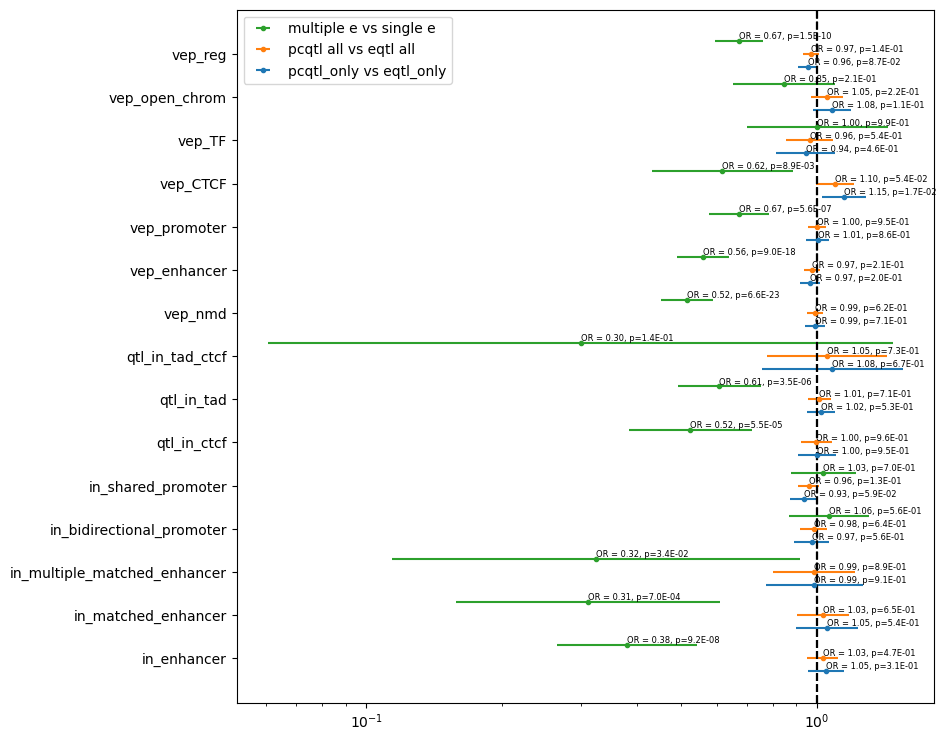

In [169]:
# log odds plot

lead_var_grouped['pcqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'pcqtl_only'
lead_var_grouped['shared_bool'] = lead_var_grouped['exclusive_label'] == 'shared'
lead_var_grouped['eqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'eqtl_only'
lead_var_grouped['multiple_e_bool'] = lead_var_grouped['num_e_samelead'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(lead_var_grouped[lead_var_grouped['exclusive_label'].isin(['pcqtl_only', 'eqtl_only'])], label_col='pcqtl_only_bool', column_list=col_names),
                                  get_odds_df(lead_var_grouped_split, label_col='pcqtl_bool', column_list=col_names), 
                                  get_odds_df(lead_var_grouped[lead_var_grouped['num_e_samelead'] >0], label_col='multiple_e_bool', column_list=col_names)], 
                                  labels=['pcqtl_only vs eqtl_only', 'pcqtl all vs eqtl all', 'multiple e vs single e'], 
                                   offset = 0.3)


in_enhancer
Optimization terminated successfully.
         Current function value: 0.657109
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31106
Model:                          Logit   Df Residuals:                    31104
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               0.0007524
Time:                        20:35:04   Log-Likelihood:                -20440.
converged:                       True   LL-Null:                       -20455.
Covariance Type:            nonrobust   LLR p-value:                 2.887e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5621      0.012    -45.799      0.000      -0.586      -0.538
in_enhancer   

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31106
Model:                          Logit   Df Residuals:                    31104
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:               0.0001319
Time:                        20:35:04   Log-Likelihood:                -20453.
converged:                       True   LL-Null:                       -20455.
Covariance Type:            nonrobust   LLR p-value:                   0.02020
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5475      0.012    -45.930      0.000      -0.571      -0.524
in_matched_enhancer     0.1746      0.075      2.336      0.020       0.028       0.321
in_multiple_matc

(0.01, 100)

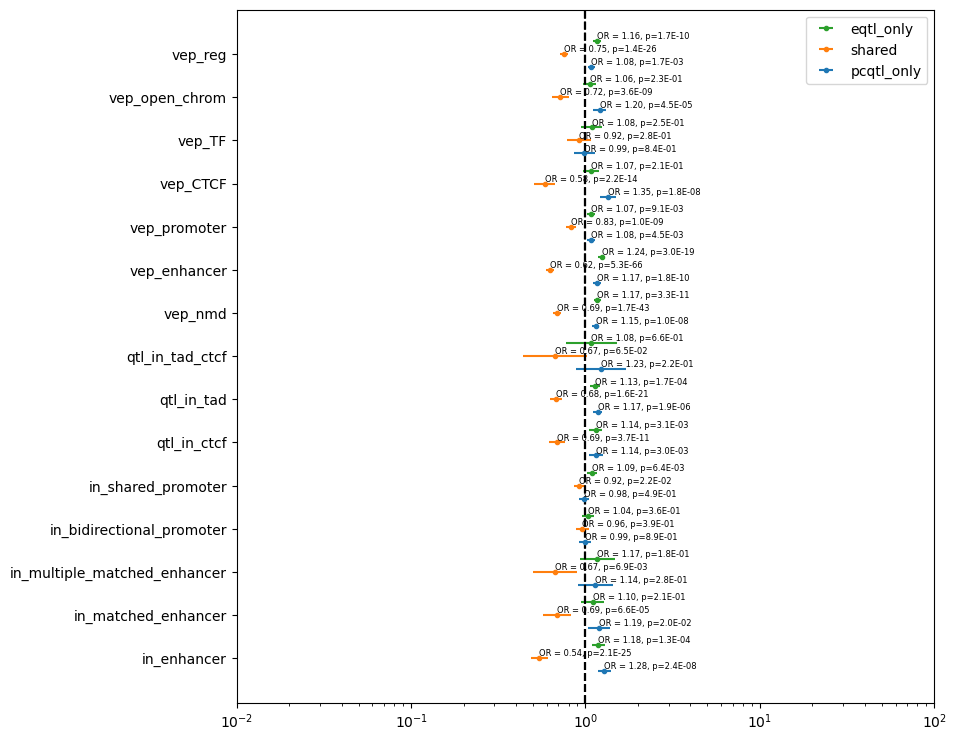

In [170]:
# log odds plot
lead_var_grouped['pcqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'pcqtl_only'
lead_var_grouped['shared_bool'] = lead_var_grouped['exclusive_label'] == 'shared'
lead_var_grouped['eqtl_only_bool'] = lead_var_grouped['exclusive_label'] == 'eqtl_only'
lead_var_grouped['multiple_e_bool'] = lead_var_grouped['num_e_samelead'] > 1

ax = make_log_odds_plot_multiple([get_odds_df(lead_var_grouped, label_col='pcqtl_only_bool', column_list=col_names),
                                  get_odds_df(lead_var_grouped, label_col='shared_bool', column_list=col_names),
                                  get_odds_df(lead_var_grouped, label_col='eqtl_only_bool', column_list=col_names)], 
                                  labels=['pcqtl_only', 'shared', 'eqtl_only'], 
                                   offset = 0.3)

ax.set_xlim(.01, 100)

## effect size

In [79]:
# get the pip-weighted egene variance explained for each phenotype
susie_annotated['egene_variance_list'] = susie_annotated['egene_variance_list'].apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].apply(ast.literal_eval)
susie_egene_explode = susie_annotated.explode(['egene_variance_list', 'egene_id_list'])
susie_egene_explode['pip_egene_variance'] = susie_egene_explode['egene_variance_list'] * susie_egene_explode['pip']

In [ ]:
# group by egene
egene_grouped = susie_egene_explode.groupby(['phenotype_id', 'tissue_id', 'cs_id', 'egene_id_list', 'cluster_id']).agg({'pip_egene_variance':'sum', 'lead_variant_id':'first', 'type':'first'})
# group into credible sets
cs_grouped = egene_grouped.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_egene_variance':'max', 'lead_variant_id':'first', 'type':'first'}).reset_index()

<AxesSubplot: xlabel='pip_egene_variance', ylabel='Density'>

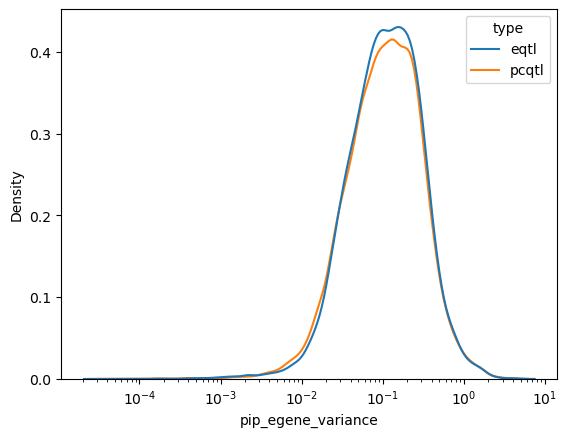

In [81]:
sns.kdeplot(cs_grouped.drop_duplicates(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']), x='pip_egene_variance', hue='type', log_scale=True)

In [82]:
# group by lead variant
# group by colocs instead TODO
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list,
                                                                                           'pip_egene_variance':'mean'})
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

(1.0434592882291931e-07, 0.14935775836402598)


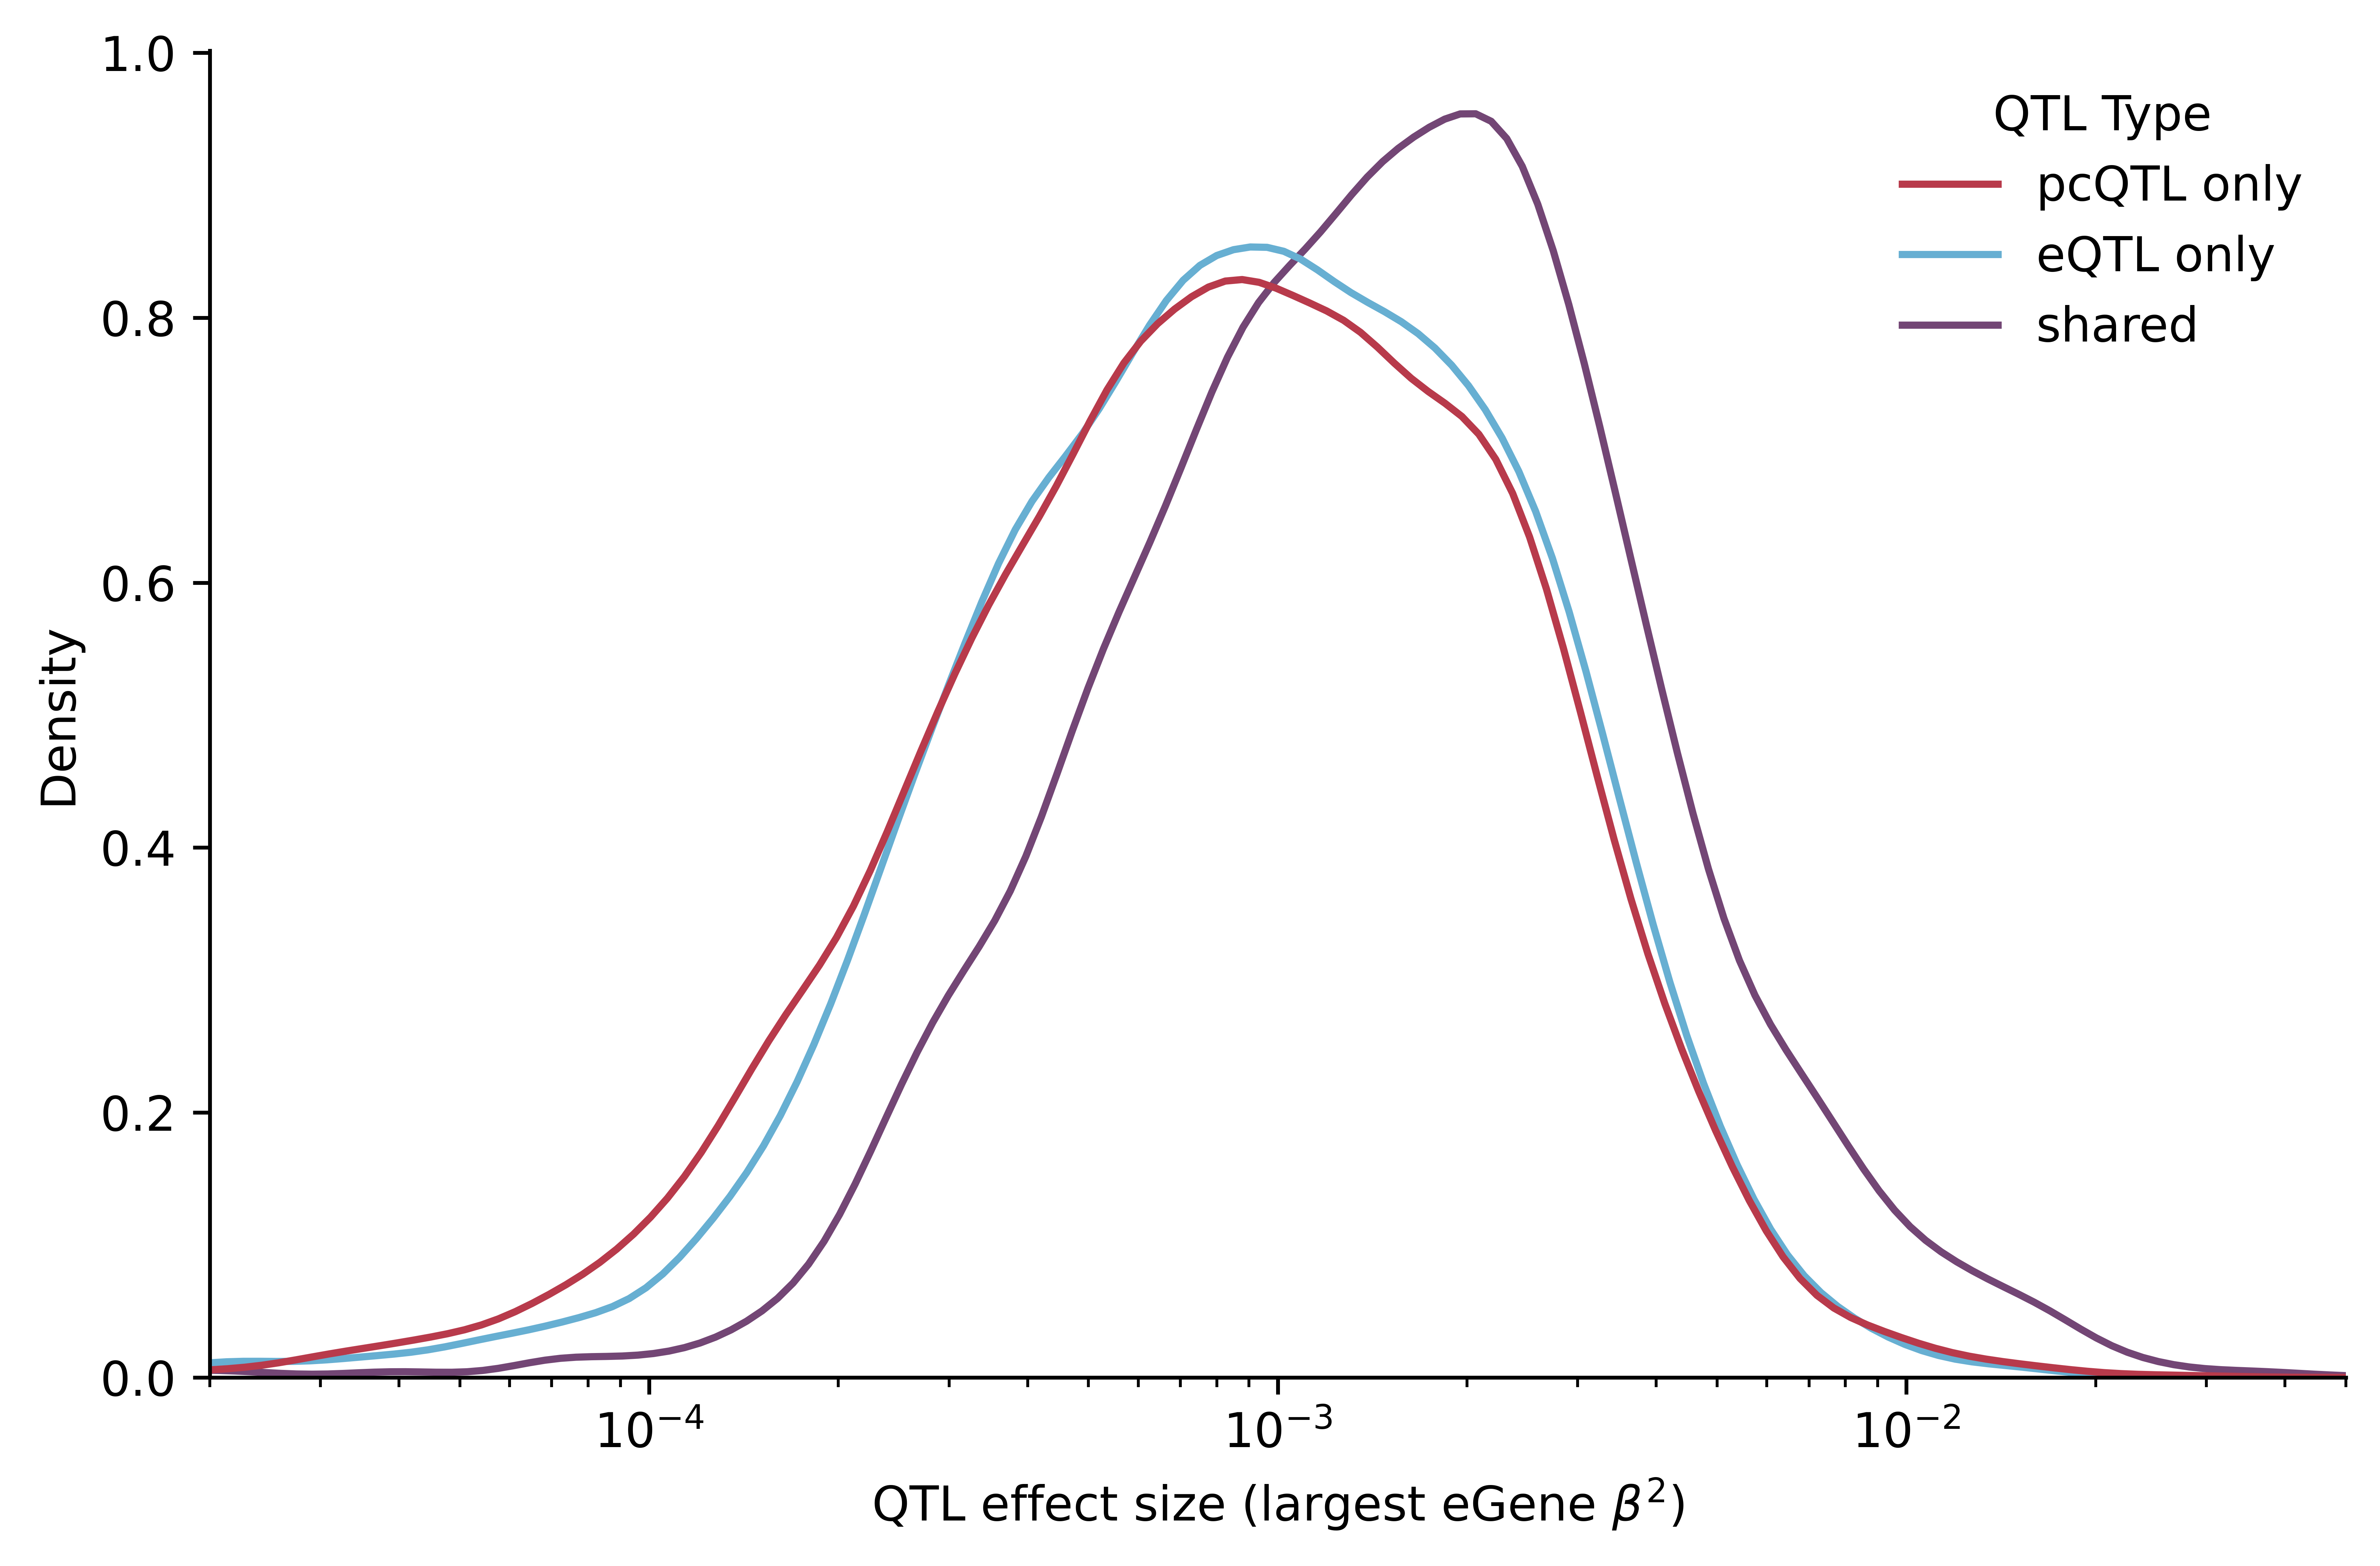

In [96]:
mpl.rcParams['figure.dpi']= 1000
fig, ax = plt.subplots(figsize=(8,5))
lead_var_grouped['pip_egene_beta2'] = lead_var_grouped['pip_egene_variance']/100
sns.kdeplot(lead_var_grouped, x='pip_egene_beta2', hue='exclusive_label', common_norm=False, log_scale=True, ax=ax,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel(r'QTL effect size (largest eGene $\beta^2$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'shared']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
print(ax.get_xlim())
ax.set_xlim(.00002, .05)
mpl.rcParams['figure.dpi']= 100

In [95]:
ttest_ind(np.log(lead_var_grouped[lead_var_grouped['exclusive_label']=='pcqtl_only']['pip_egene_beta2'].astype(float)), np.log(lead_var_grouped[lead_var_grouped['exclusive_label']=='eqtl_only']['pip_egene_beta2'].astype(float)))

Ttest_indResult(statistic=-5.236452788410793, pvalue=1.6510717242178536e-07)

## allele freqs

<AxesSubplot: xlabel='minor_af', ylabel='Count'>

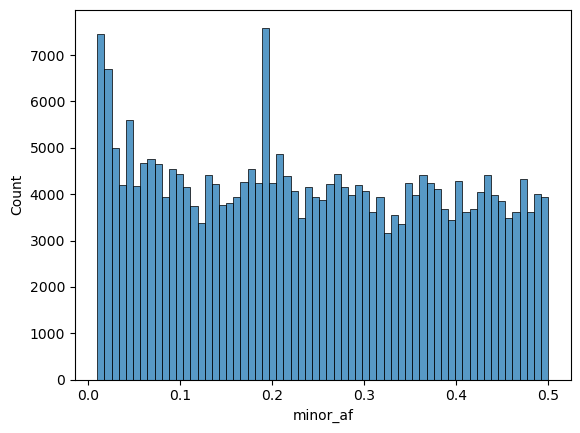

In [44]:
susie_annotated['minor_af'] = np.where(susie_annotated['af']>.5, 1-susie_annotated['af'], susie_annotated['af'])
sns.histplot(susie_annotated.drop_duplicates('variant_id')['minor_af'])

<AxesSubplot: ylabel='Count'>

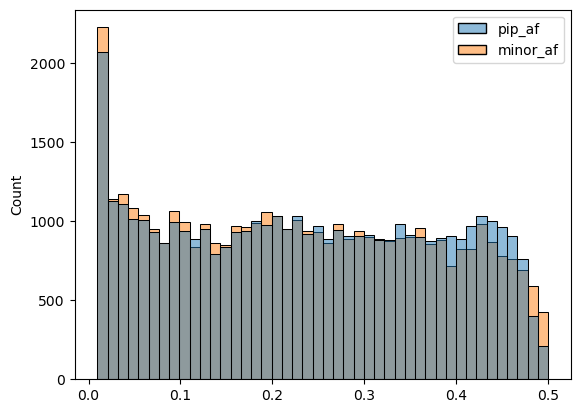

In [58]:
# weight by pip
susie_annotated['pip_af'] = susie_annotated['minor_af'] * susie_annotated['pip']
# group into credible sets
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_af':'sum', 'lead_variant_id':'first', 'minor_af':'min', 'type':'first'}).reset_index()
sns.histplot(cs_grouped, )

<AxesSubplot: xlabel='pip_af', ylabel='Proportion'>

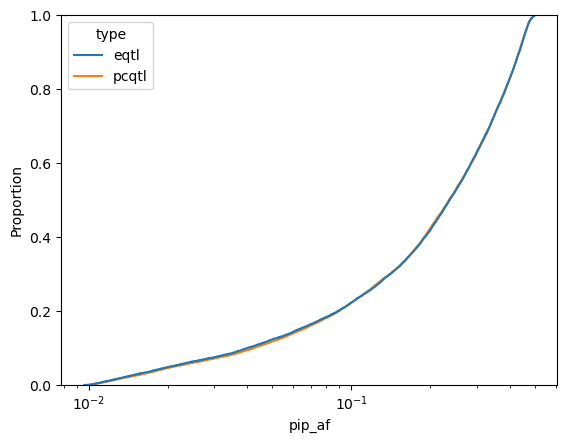

In [64]:
sns.ecdfplot(cs_grouped.drop_duplicates(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']), x='pip_af', hue='type', log_scale=True)

In [55]:
# group by lead variant
# group by colocs instead TODO
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list,
                                                                                           'pip_af':'mean',
                                                                                           'minor_af':'min'})
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

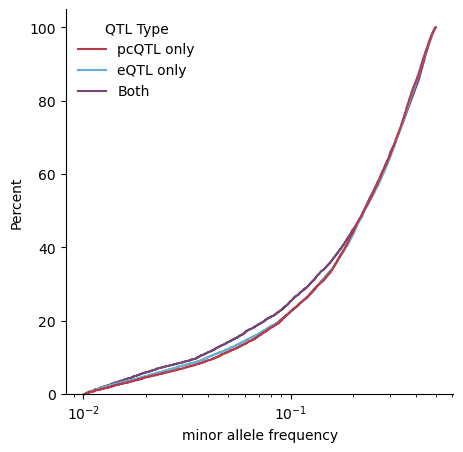

In [56]:
fig, ax = plt.subplots(figsize=(5,5))
sns.ecdfplot(lead_var_grouped, x='minor_af', hue='exclusive_label',  stat="percent", ax=ax, log_scale=True,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel('minor allele frequency')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

# CV
should this be in egene space?

In [52]:
susie_annotated['pip_cv'] = susie_annotated['qtl_slope_se']/susie_annotated['qtl_slope'].abs() * susie_annotated['pip']
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_cv':'sum', 'lead_variant_id':'first'}).reset_index()

<AxesSubplot: ylabel='Count'>

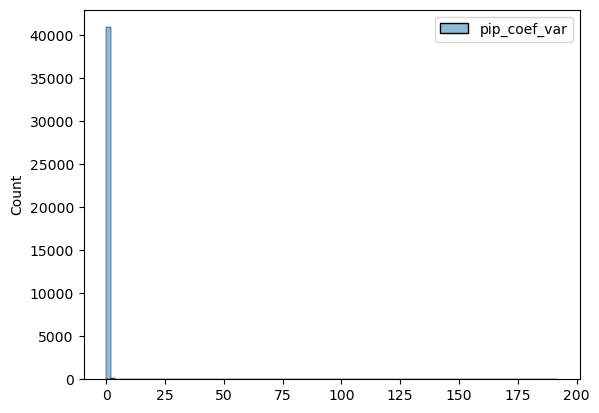

In [51]:
sns.histplot(cs_grouped, bins=100)

In [53]:
# group by lead variant
# group by colocs instead TODO
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list,
                                                                                           'pip_cv':'mean'})
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [57]:
lead_var_grouped.groupby('exclusive_label').agg({'pip_cv':'median'})

pip_cv
exclusive_label          
eqtl_only        0.136141
pcqtl_only       0.142270
shared           0.111190

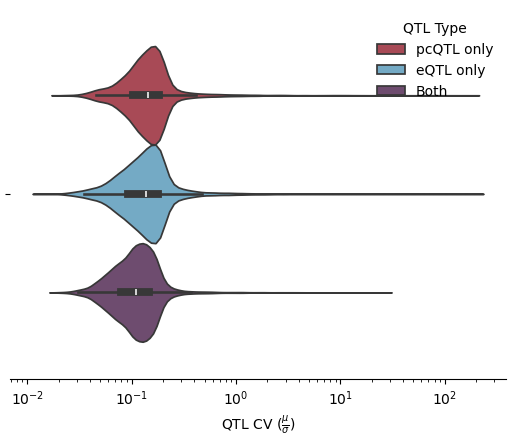

In [67]:
ax = sns.violinplot(lead_var_grouped, x='pip_cv', hue='exclusive_label', log_scale=True, 
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel(r'QTL CV ($\frac{\mu}{\sigma}$)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

<AxesSubplot: xlabel='pip_cv', ylabel='Percent'>

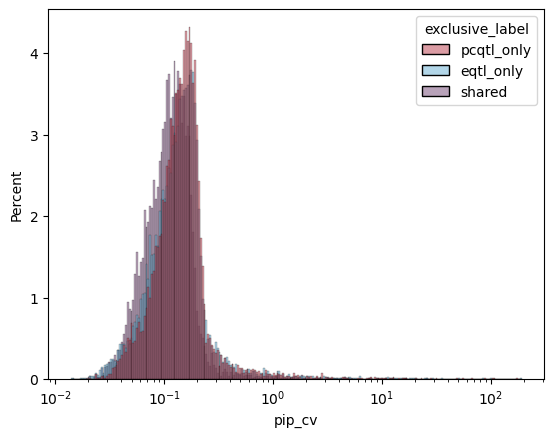

In [61]:
sns.histplot(lead_var_grouped, x='pip_cv', hue='exclusive_label', common_norm=False, log_scale=True, stat='percent',
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])


(0.00610079675025558, 433.97103707836504)


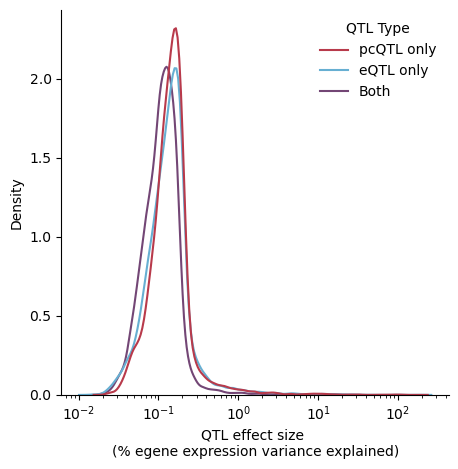

In [59]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(lead_var_grouped, x='pip_cv', hue='exclusive_label', common_norm=False, log_scale=True, ax=ax,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel('QTL effect size \n(% egene expression variance explained)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
print(ax.get_xlim())
#ax.set_xlim(0, 2)

## old code

In [174]:
# load in the data from all tissues
vep_df = load_across_tissues(config, load_vep)
vep_df['variant_id'] = vep_df['ID']

In [175]:
# test out removing 1 var credible sets??
vep_df['num_vars'] = vep_df['variant_list'].apply(ast.literal_eval).apply(len)
print(len(vep_df))
#vep_df = vep_df[vep_df['num_vars']>1]
print(len(vep_df))


41146
41146


In [176]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [177]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
qtls_grouped = vep_df.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_full_id':list, 
                                                                                'INFO':'first', 
                                                                                'orig_cs_dataset':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'lead_variant_pos':'first', 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_e_')/2
qtls_grouped['num_pc_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


In [178]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes = qtls_grouped[qtls_grouped['exclusive_label']=='shared'].explode(['orig_cs_dataset', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).agg({'num_vars':min})
cs_sizes_pivot = cs_sizes.pivot_table(index='lead_variant_id', 
                           columns='orig_cs_dataset', 
                           values='num_vars', 
                           fill_value=0).reset_index()

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

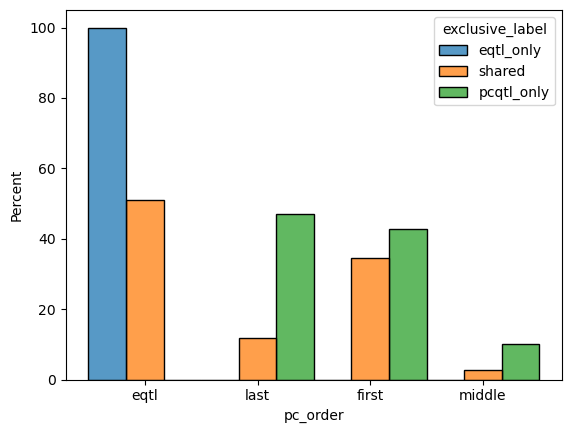

In [117]:
sns.histplot(qtls_grouped.explode('pc_order'), hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

In [118]:
vep_df = qtls_grouped

## VEP
vep annotates with variant categories

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [119]:
# as an example
vep_df.iloc[4].INFO

'CSQ=T|intron_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000370397|protein_coding||16/20||||||||rs7910533||-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000585551|protein_coding_CDS_not_defined||||||||||rs7910533|3816|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000588656|protein_coding_CDS_not_defined||||||||||rs7910533|3160|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000590930|protein_coding_CDS_not_defined||||||||||rs7910533|1297|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||'

In [120]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [121]:
# make a list of the tissues for each ID
tissue_list = vep_df.groupby('lead_variant_id')['tissue_id'].apply(list)
vep_df['tissue_list'] = vep_df['lead_variant_id'].map(tissue_list)

In [122]:
# vep df should not be deduplicated I think
# just be sure to keep the orig dataset in mind 
#vep_df = vep_df.drop_duplicates('ID')

#### Consequence

In [123]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

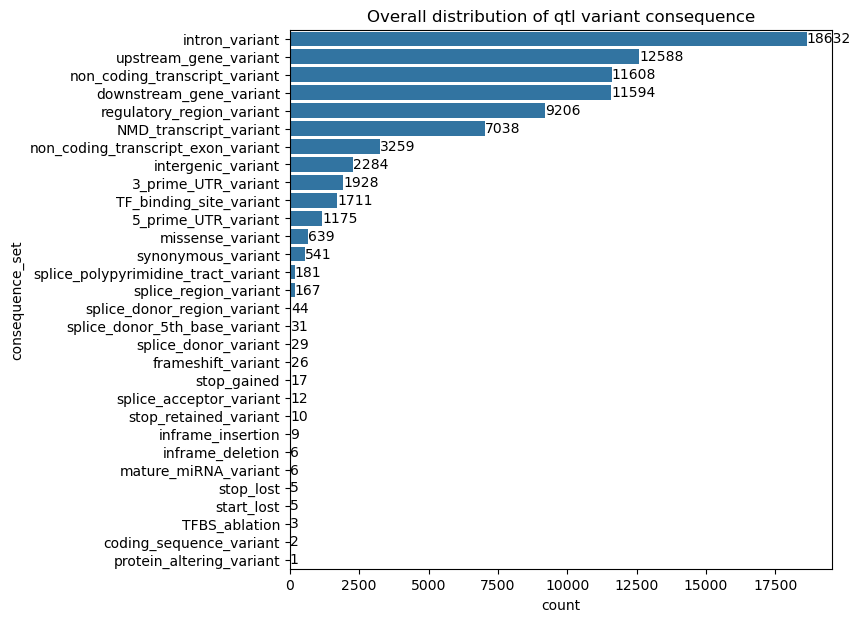

In [124]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_c_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

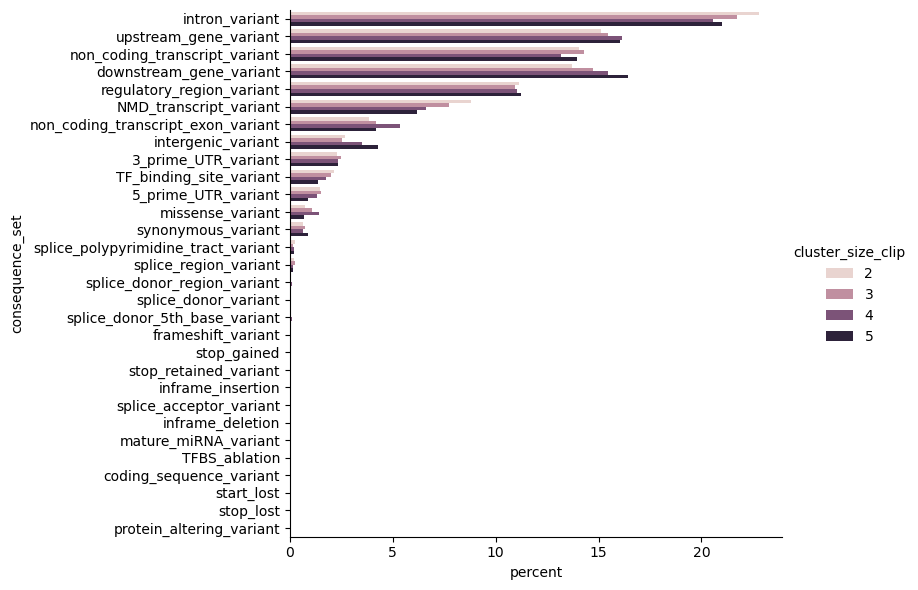

In [125]:
vep_df['cluster_size_clip'] = vep_df['cluster_size'].clip(0,5)
data_to_plot = vep_df.explode('consequence_set').groupby('cluster_size_clip')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='cluster_size_clip',kind='bar',height=6, aspect=1.4)


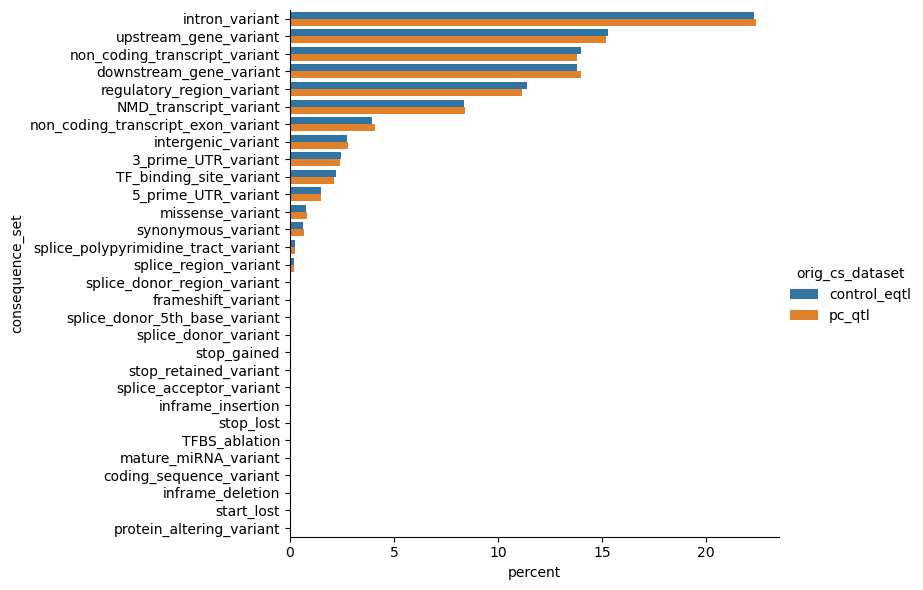

In [136]:
data_to_plot = vep_df.explode('orig_cs_dataset').explode('consequence_set').groupby('orig_cs_dataset')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='orig_cs_dataset',kind='bar', height=6, aspect=1.4)

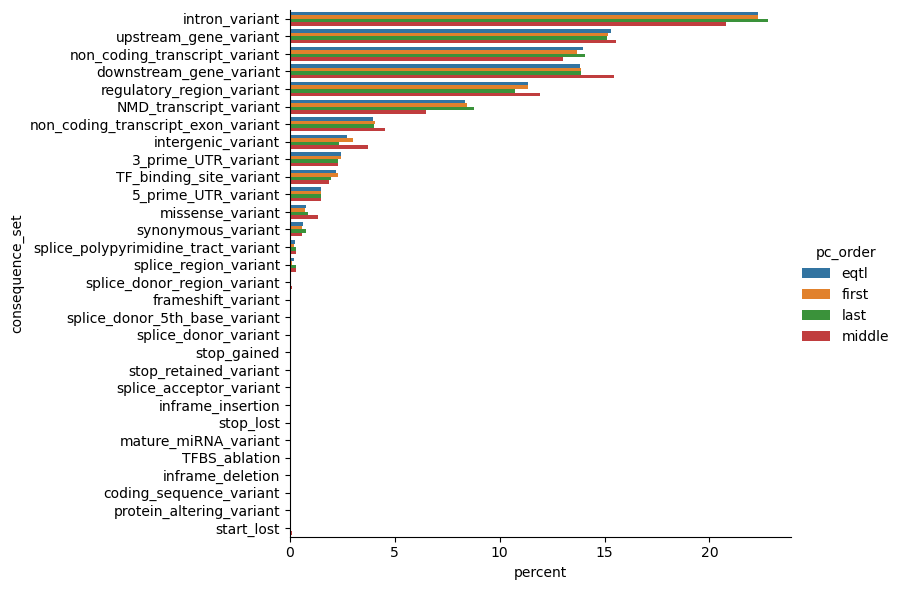

In [137]:
data_to_plot = vep_df.explode('pc_order').explode('consequence_set').groupby('pc_order')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


##### log odds

In [138]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df, key_col='consequence_set'):
    return vep_df.explode(key_col).value_counts(key_col)

def get_odds_df(counts1, name1, counts2, name2, ordered_categories):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title, key_col='consequence_set', ax=None, offset=-.2):
    if ax==None:
        fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df[key_col], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)+offset, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)+offset, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    return ax

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant consequences'}>

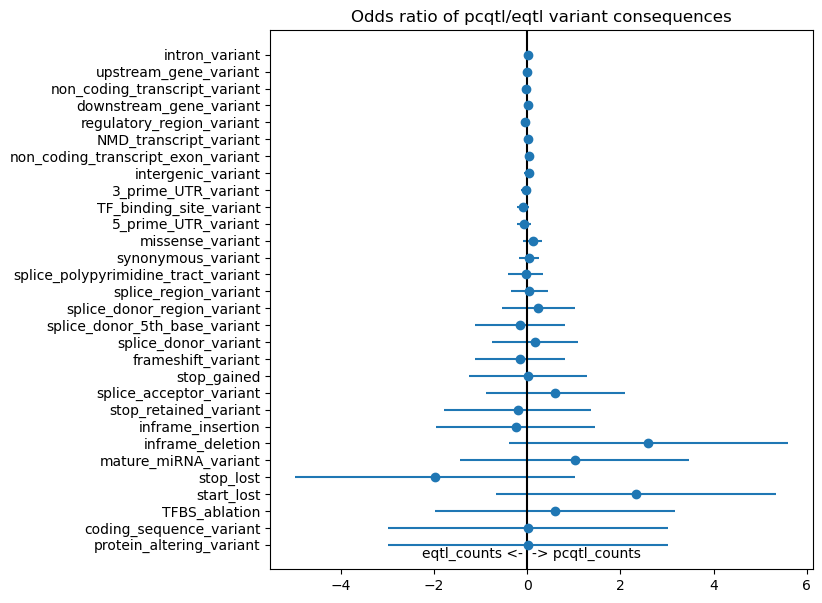

In [139]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of exclusive eqtl/all eqtl variant consequences'}>

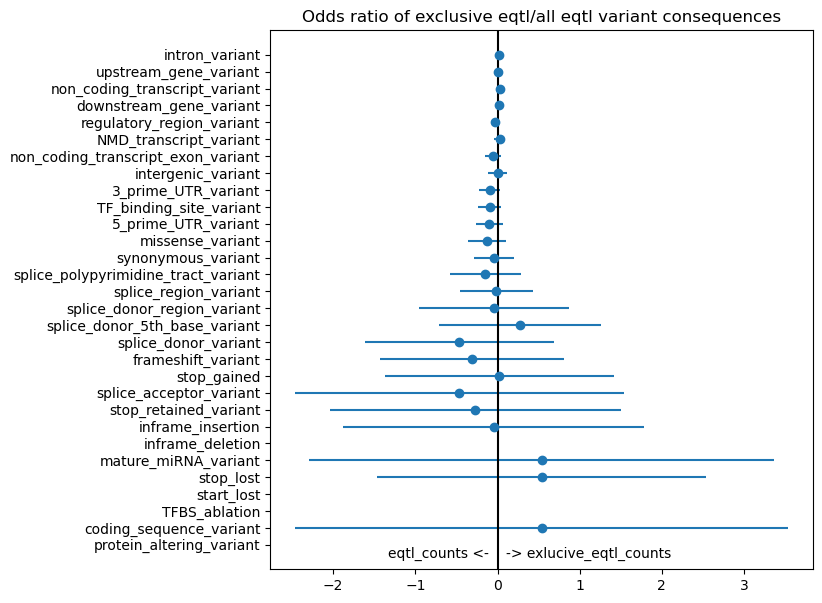

In [140]:
exclusive_eqtl_counts = get_or_counts(vep_df[(vep_df['exclusive_label']=='eqtl_only')])
eqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset'].astype(str).str.contains('control_eqtl'))])

# format into a df and get the error bars
or_df = get_odds_df(exclusive_eqtl_counts, 'exlucive_eqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of exclusive eqtl/all eqtl variant consequences')

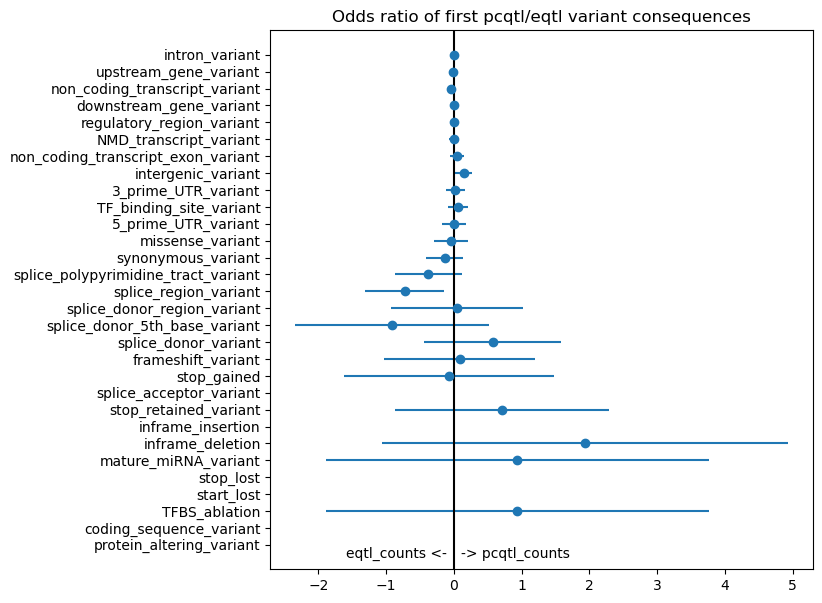

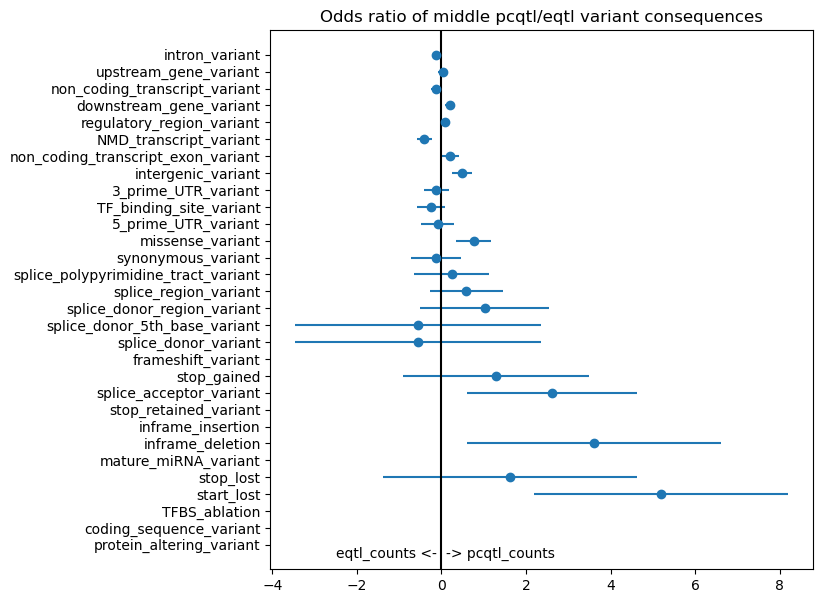

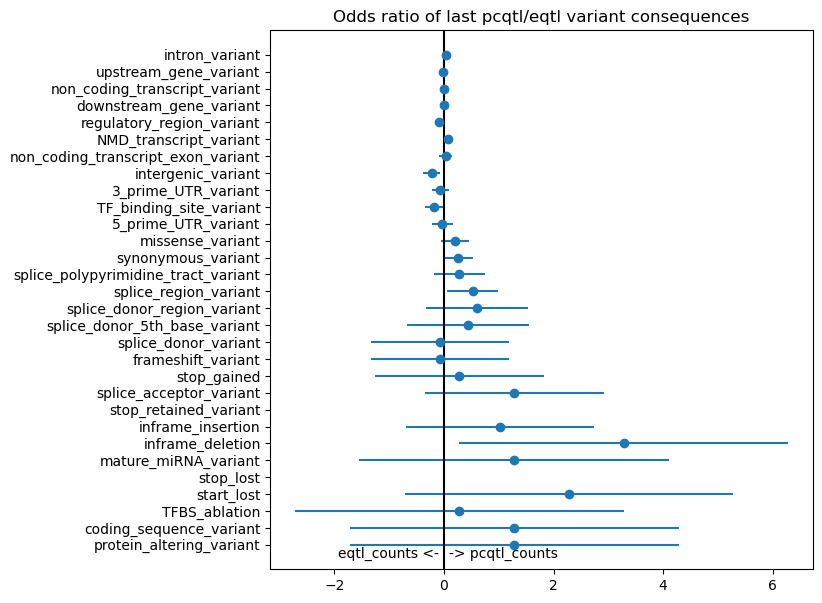

In [141]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))])
    eqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset'].astype(str).str.contains('control_eqtl'))])

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_c_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant consequences'}>

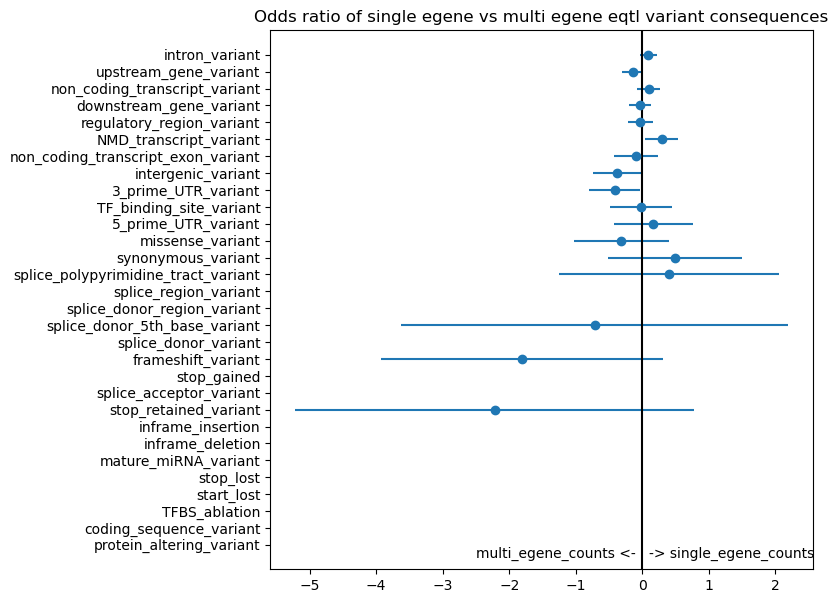

In [149]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']==1)])
multi_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>1)])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### Biotype

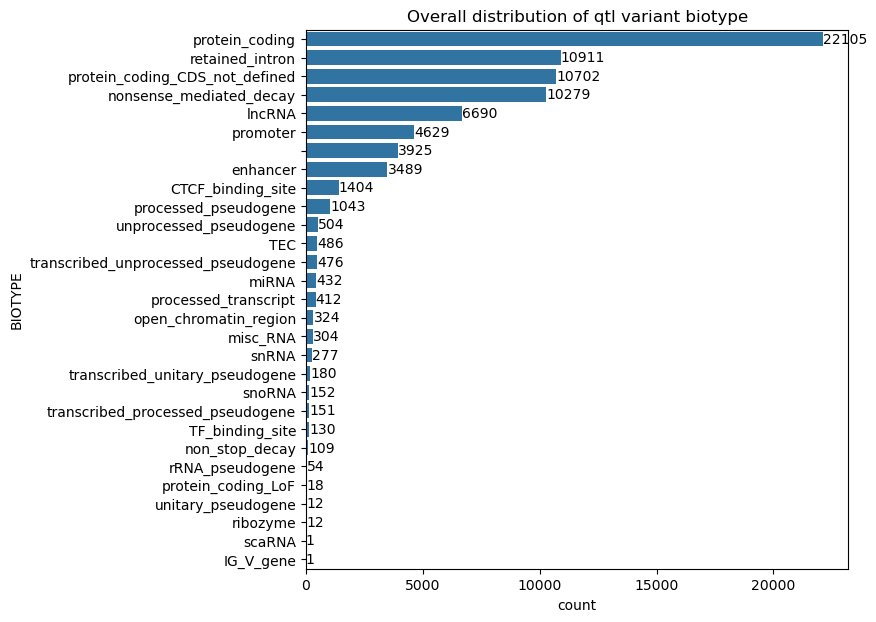

In [150]:
# overall distribution of biotype
fig, ax = plt.subplots(figsize=(7,7))
ordered_b_categories = vep_df.explode('BIOTYPE')['BIOTYPE'].value_counts().index
y = sns.countplot(vep_df.explode('BIOTYPE'), y='BIOTYPE', ax=ax, order=ordered_b_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant biotype')
plt.show()

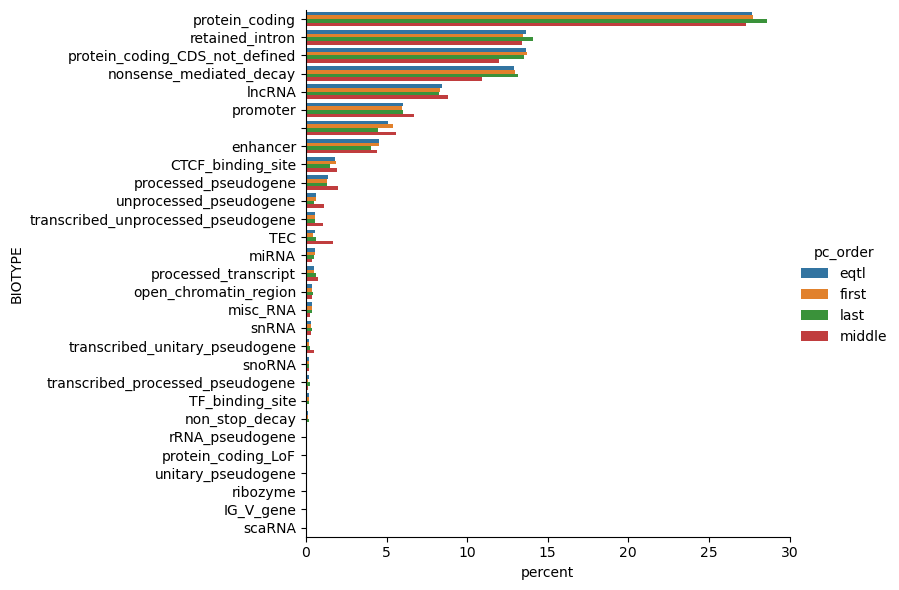

In [152]:
data_to_plot = vep_df.explode('pc_order').explode('BIOTYPE').groupby('pc_order')['BIOTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='BIOTYPE',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant biotype'}>

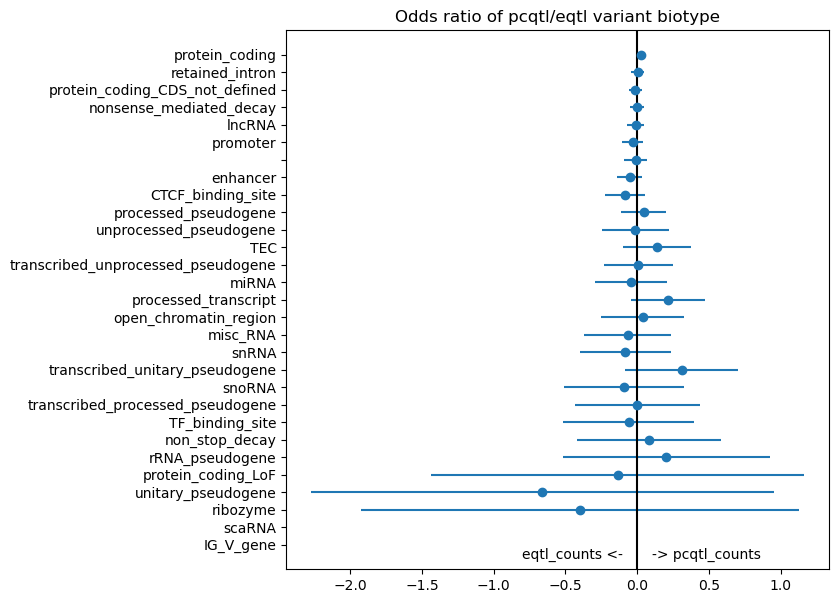

In [153]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)], key_col='BIOTYPE')
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant biotype', key_col='BIOTYPE')

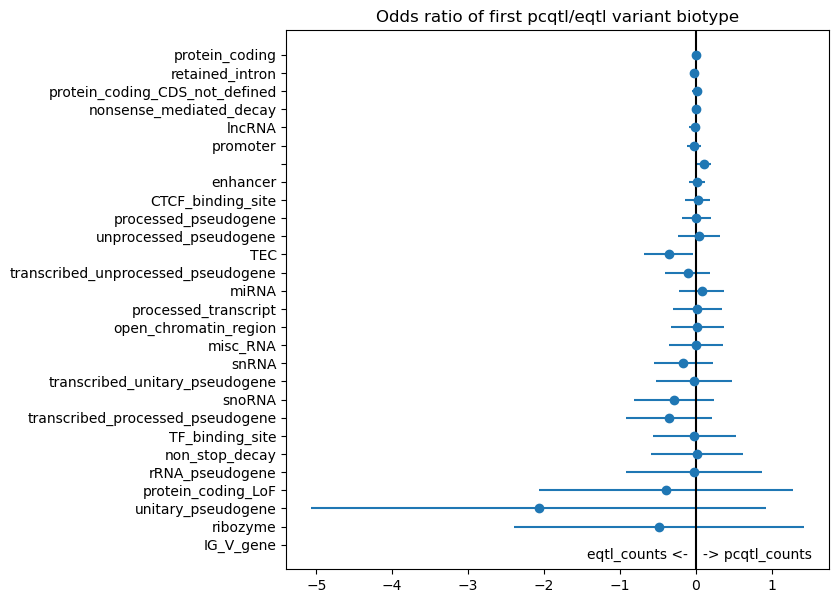

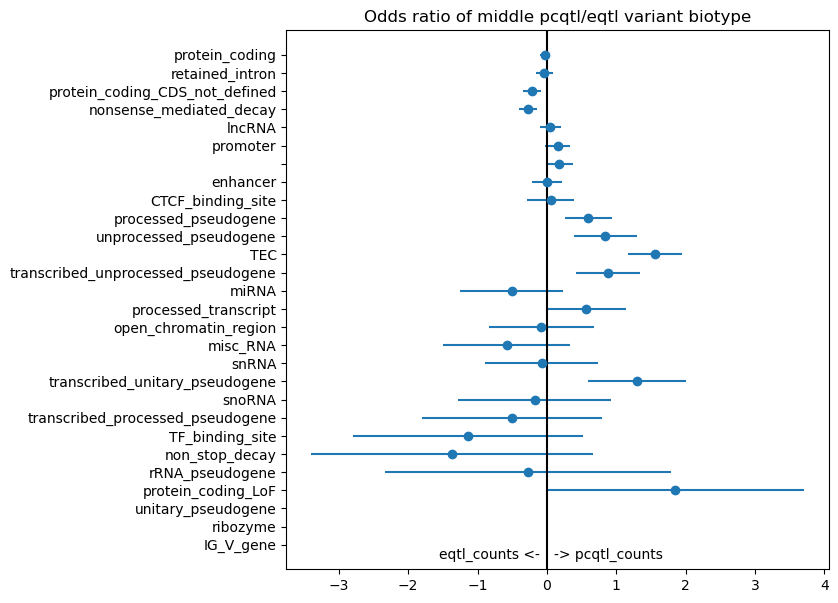

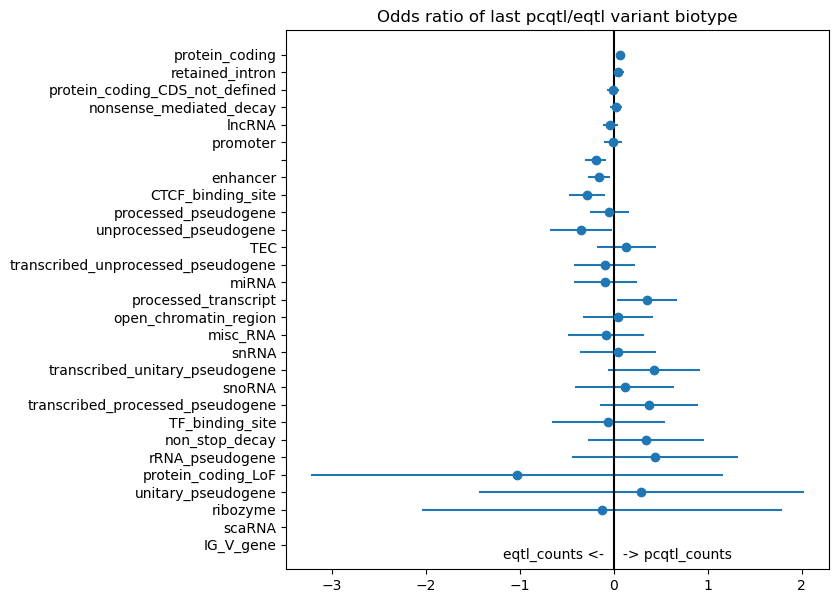

In [155]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))],  key_col='BIOTYPE')
    eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)],  key_col='BIOTYPE')

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='BIOTYPE')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant biotype'}>

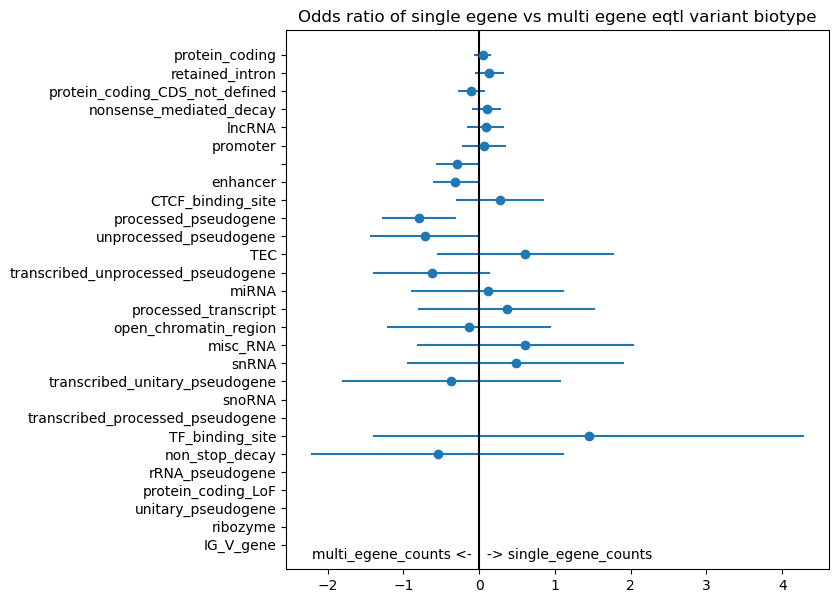

In [156]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']==1)], key_col='BIOTYPE')
multi_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>1)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant biotype', key_col='BIOTYPE')

### Transcription factors

In [157]:
# TFs are split with :: and &
def split_tfs(row):
    split_tfs = [indv_tf for tf in row['TRANSCRIPTION_FACTORS'] for indv_tf in tf.split('&')]
    split_tfs = [indv_tf for tf in split_tfs for indv_tf in tf.split('::')]
    return list(set(split_tfs))

vep_df['tf_set'] = vep_df.apply(split_tfs, axis=1)

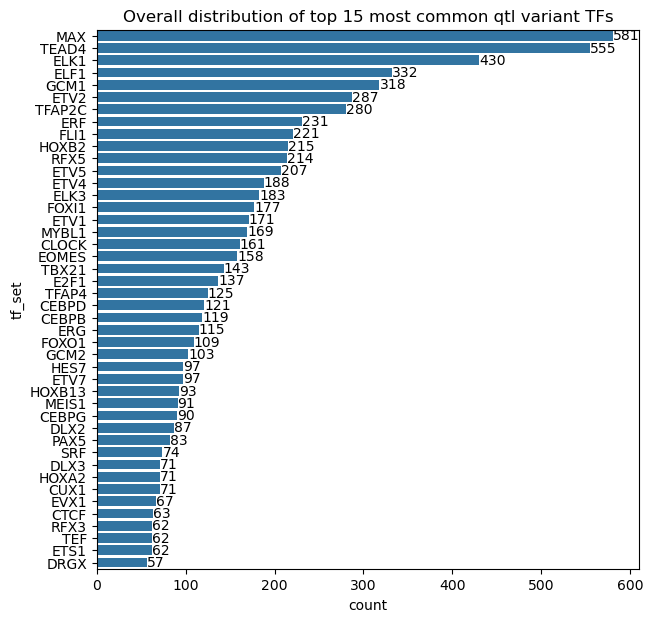

In [158]:
# overall distribution of transcription factors
fig, ax = plt.subplots(figsize=(7,7))
ordered_t_categories = vep_df.explode('tf_set')['tf_set'].value_counts().index
subsample_df = vep_df.explode('tf_set')
subsample_df = subsample_df[subsample_df['tf_set'].isin(ordered_t_categories[1:45])]
y = sns.countplot(subsample_df, y='tf_set', ax=ax, order=ordered_t_categories[1:45])
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of top 15 most common qtl variant TFs')
plt.show()

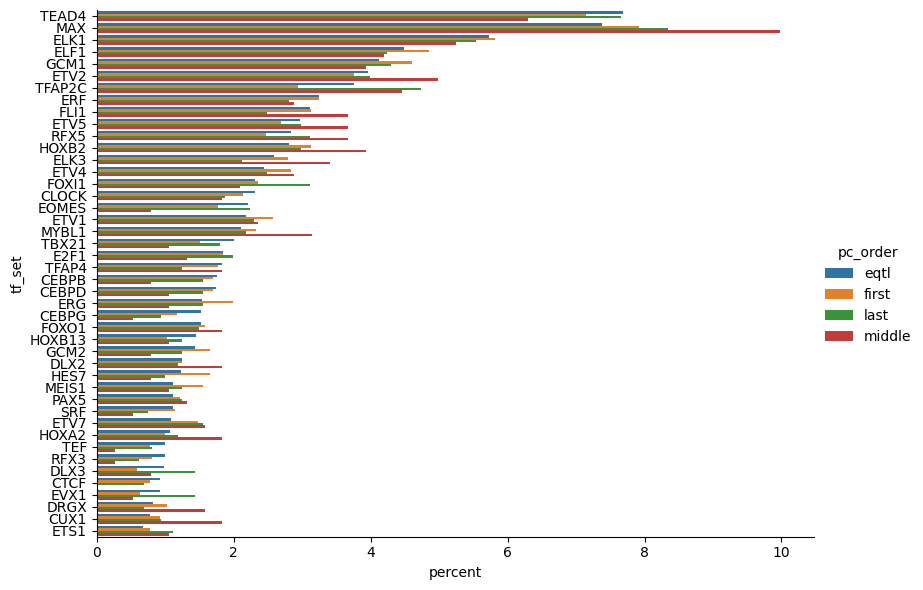

In [160]:
data_to_plot = subsample_df.explode('pc_order').explode('tf_set').groupby('pc_order')['tf_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='tf_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant tf'}>

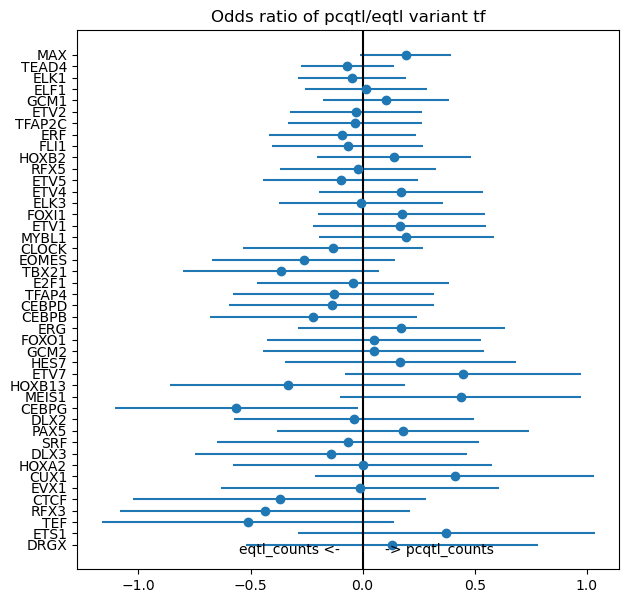

In [161]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(subsample_df[(subsample_df['num_pc_samelead']>0)], key_col='tf_set')
eqtl_counts = get_or_counts(subsample_df[(subsample_df['num_e_samelead']>0)], key_col='tf_set')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_t_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant tf', key_col='tf_set')

## for presnetaitons

highlight a few interesting columns


**consequence**

NMD 

regulatory

TF binding

**biotype**

CTCF

enhancer

promotor

In [162]:
def selected_feature_or_df(df1, name1, df2, name2, features):
    # get biotype df
    df1_counts = get_or_counts(df1, key_col='BIOTYPE')
    df2_counts = get_or_counts(df2, key_col='BIOTYPE')

    # format into a df and get the error bars
    bio_or_df = get_odds_df(df1_counts, name1, df2_counts, name2 , ordered_categories=ordered_b_categories)

    # gert conseqeucne df
    df1_counts = get_or_counts(df1)
    df2_counts = get_or_counts(df2)

    # format into a df and get the error bars
    cons_or_df = get_odds_df(df1_counts, name1, df2_counts, name2, ordered_c_categories)

    # make into one df
    bio_or_df=bio_or_df.rename(columns={'BIOTYPE':'feature'})
    cons_or_df = cons_or_df.rename(columns={'consequence_set':'feature'})

    or_df = pd.concat([bio_or_df, cons_or_df])
    return or_df.set_index('feature').loc[features].reset_index()

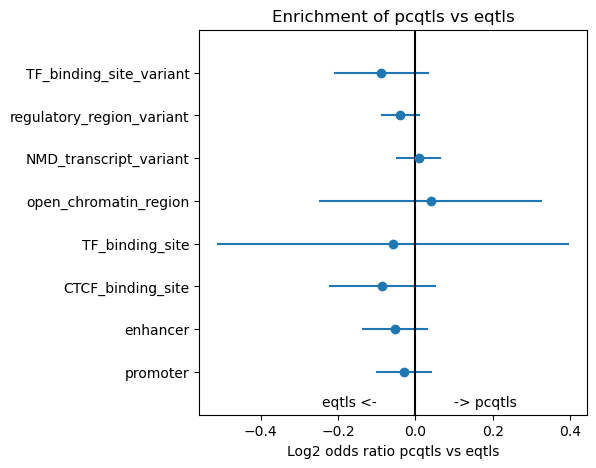

In [169]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['num_pc_samelead']>0], 'pcqtls', vep_df[vep_df['num_e_samelead']>0], 'eqtls', features)



fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio pcqtls vs eqtls')

#ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


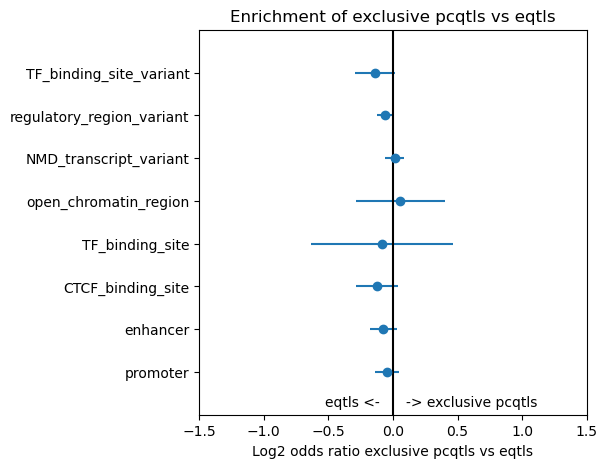

In [172]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['num_e_samelead']==0], 'exclusive pcqtls', vep_df[vep_df['num_pc_samelead']==0], 'eqtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of exclusive pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio exclusive pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


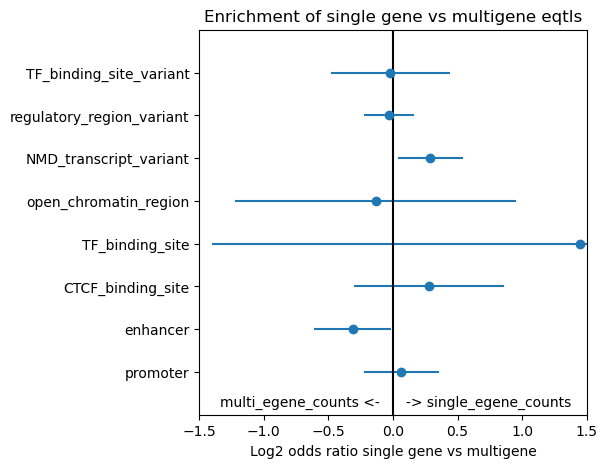

In [167]:

# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']==1)], 'single_egene_counts', vep_df[(vep_df['num_e_samelead']>1)], 'multi_egene_counts', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of single gene vs multigene eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()

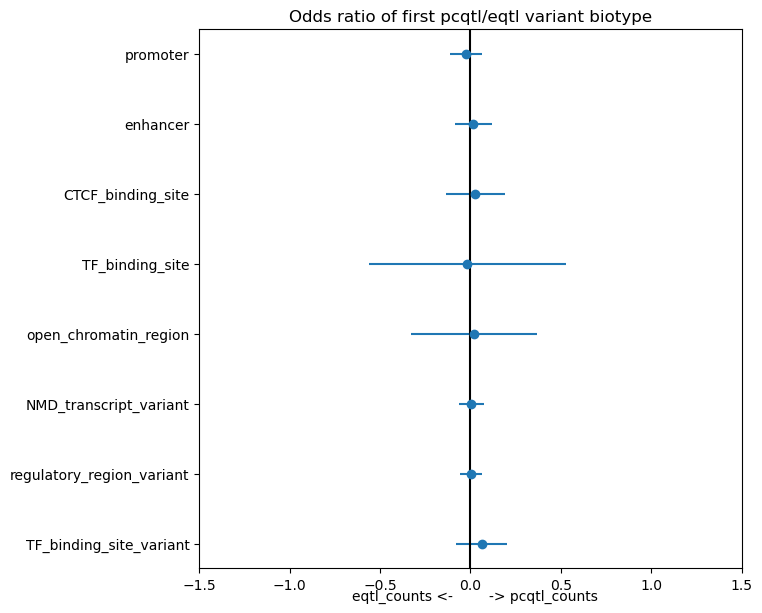

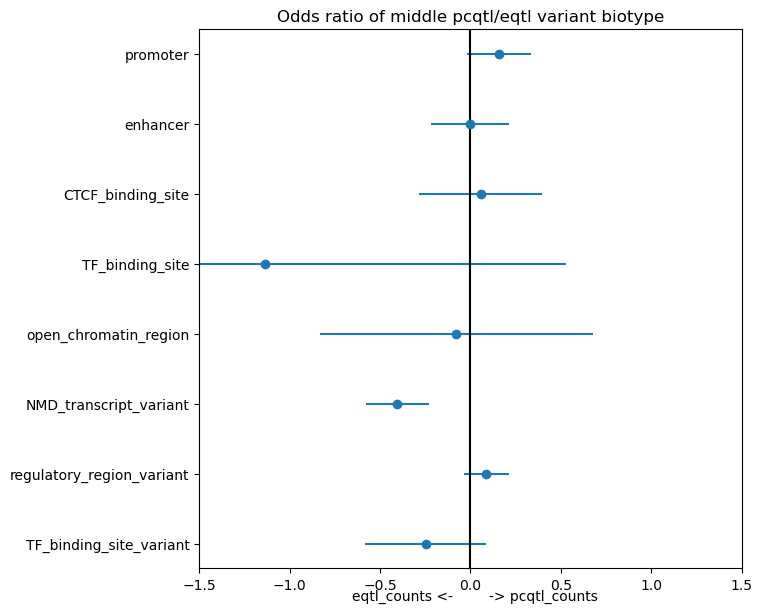

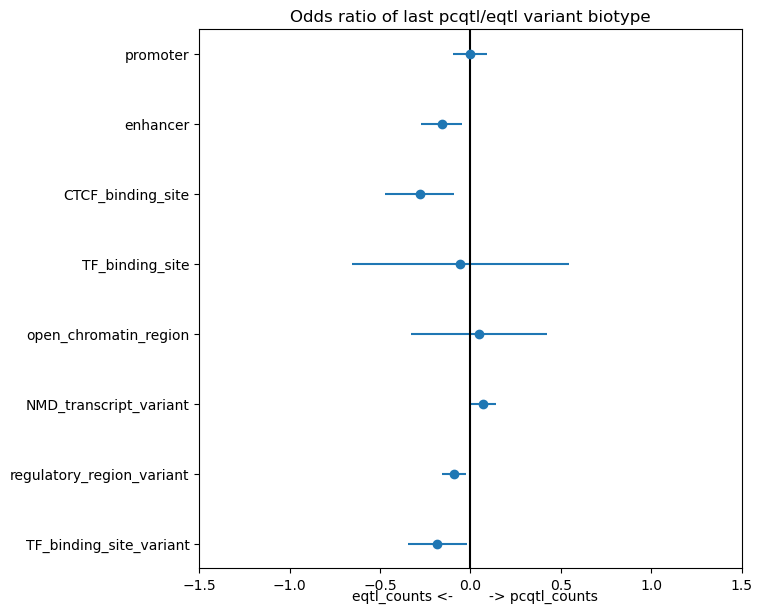

In [168]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    # format into a df and get the error bars
    or_df = selected_feature_or_df(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))], 'pcqtl_counts', vep_df[(vep_df['num_e_samelead']>0)], 'eqtl_counts', features)
    # plot
    ax = plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='feature')
    ax.set_xlim(-1.5, 1.5)
